# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import ptitprince as pt

from scipy.stats import pearsonr
import statsmodels.api as sm

# Load Data

In [3]:
df = pd.read_csv('../02_analysis/df_good.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_87757/882331396.py:1: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../02_analysis/df_good.csv')


## Battery

In [4]:
battery1 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_1/run1_fullDataframe.csv')
battery2a = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_2/battery_cohort2_offB.csv')
battery2b = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_2/battery_cohort2_onB.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_87757/67091204.py:1: DtypeWarning: Columns (76,98,99,100,101,112,114,129,132,154,158,187,220,240,338,358,411,412,417,418,420,421,453,454,455,474,481,488,495,502,2088,2217,2218,2219,2226,2227,2228,2236,2253,2254,2259,2260,2262,2263,2295,2296,2297,2316,2323,2330,2337,2344,3930,4059,4060,4061,4068,4069,4070,4078) have mixed types. Specify dtype option on import or set low_memory=False.
  battery1 = pd.read_csv('/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/run_1/run1_fullDataframe.csv')


In [5]:
# Drop column
battery2a.drop(columns='student_id', inplace=True)
battery2b.drop(columns='student_id', inplace=True)

# Prepend text to every column except 'ParticipantIdentifier'
prepend_text = "onB_"
battery2a.columns = [prepend_text + col if col != 'ParticipantIdentifier' else col for col in battery2a.columns]

prepend_text = "offB_"
battery2b.columns = [prepend_text + col if col != 'ParticipantIdentifier' else col for col in battery2a.columns]

battery2 = battery2a.merge(battery2b, how='outer', on='ParticipantIdentifier')

# Rename column
battery2.rename(columns = {'ParticipantIdentifier': 'PID'}, inplace=True)

In [6]:
# This is daily data, so only need one value for battery measures
battery1 = battery1.drop_duplicates(subset=['ParticipantIdentifier'])
battery1.rename(columns={'ParticipantIdentifier': 'PID'}, inplace=True)

In [7]:
battery = pd.concat([battery1, battery2], ignore_index=True)

In [15]:
# How many passive variables?

x = len([col for col in df.columns if 'passive' in col])
print(f'Number of passive variables: {x}') 

x = len([col for col in df.columns if '_hk_' in col])
print(f'Number of health kit variables: {x}') 

x = len([col for col in df.columns if '_sk_' in col])
print(f'Number of sensor kit variables: {x}') 

Number of passive variables: 129
Number of health kit variables: 16
Number of sensor kit variables: 113


## Health Kit

In [16]:
[col for col in df.columns if '_hk_' in col]

['passive_hk_activity_activeEnergyBurned',
 'passive_hk_activity_appleStandTime',
 'passive_hk_activity_distanceCycling',
 'passive_hk_activity_distanceWalkingRunning',
 'passive_hk_activity_restingEnergyBurned',
 'passive_hk_activity_steps',
 'passive_hk_activity_averageWalkingSpeed',
 'passive_hk_hr_variability',
 'passive_hk_hr_resting',
 'passive_hk_hr_averageWalking',
 'passive_hk_sleep_asleep',
 'passive_hk_sleep_core',
 'passive_hk_sleep_deep',
 'passive_hk_sleep_REM',
 'passive_hk_sleep_awake',
 'passive_hk_sleep_inBed']

In [19]:
# Filter columns that contain "_hk_"
hk_columns = [col for col in df.columns if '_hk_' in col]

# Select only the filtered columns along with the PID for aggregation
df_hk = df[['PID'] + hk_columns]

# Calculate the average number of responses by PID for each _hk_ column
average_responses_by_pid = df_hk.groupby('PID').mean().reset_index()

# Calculate the number of trial days (rows with numeric data) for each _hk_ column by PID
trial_days_by_pid = df_hk.groupby('PID').count().reset_index()

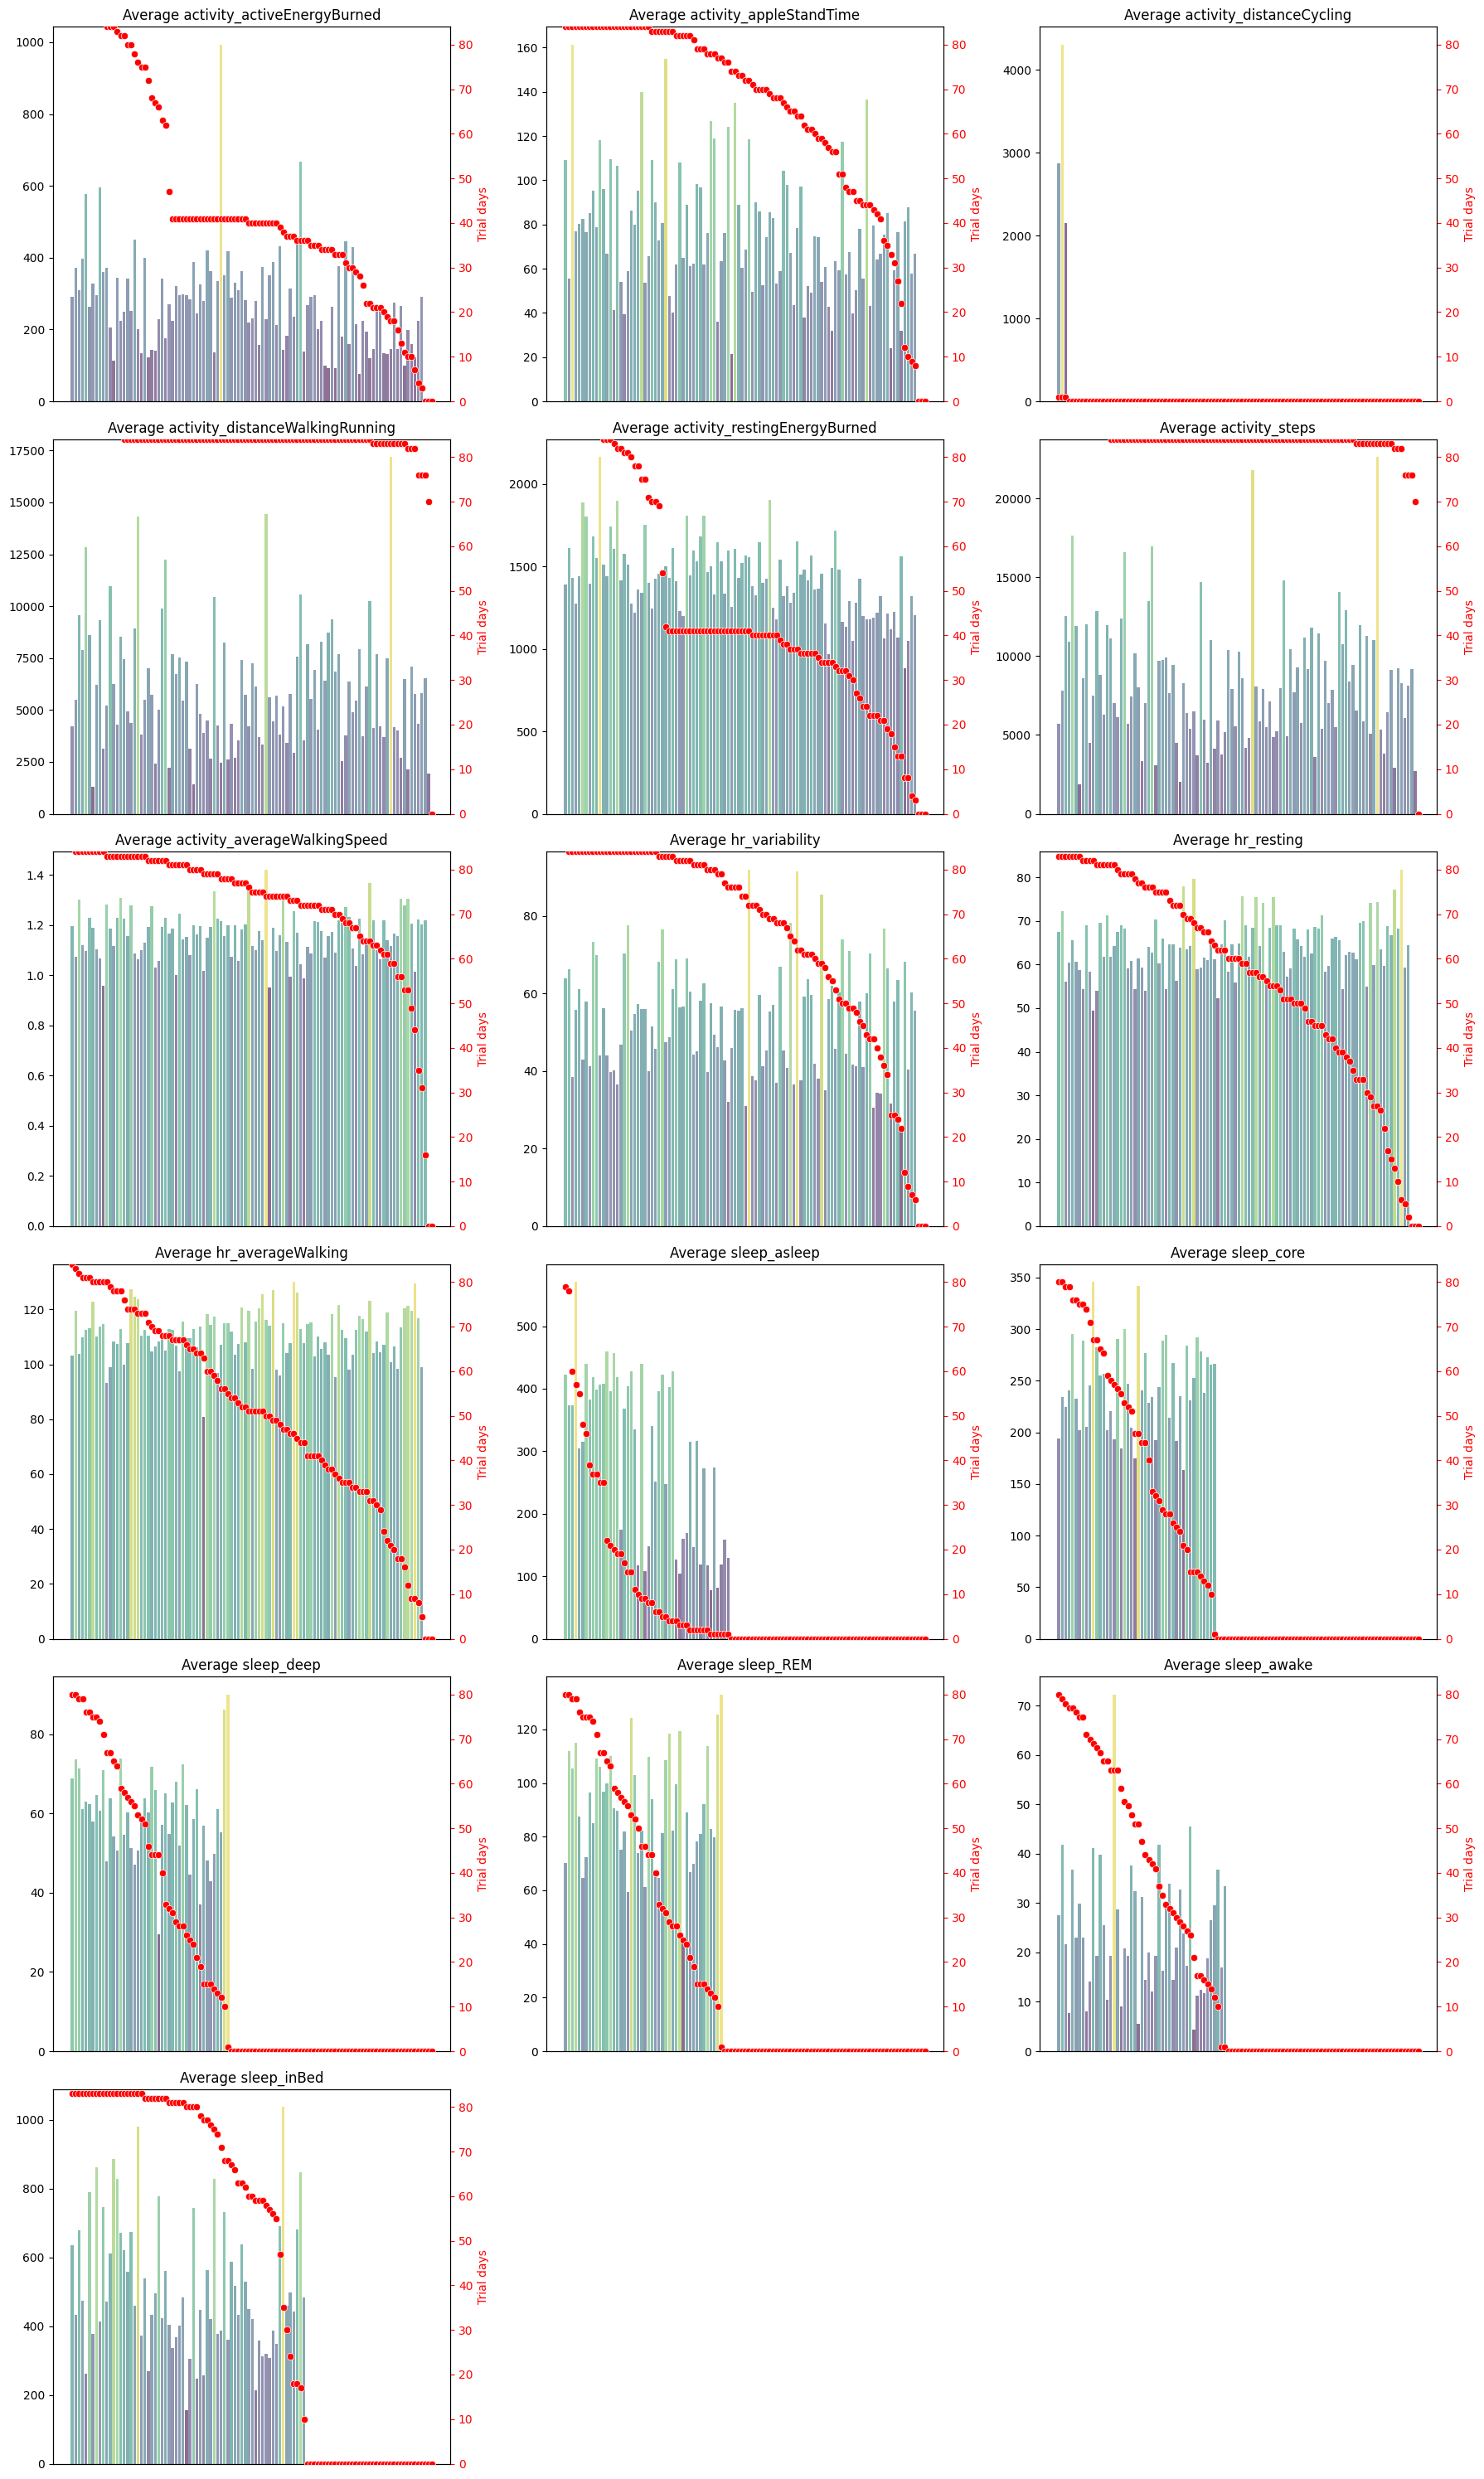

In [32]:
# Filtering columns for visualization based on non-NaN coverage
columns_to_visualize = [col for col in df.columns if '_hk_' in col]

# Create a figure to hold the subplots, adjusting for 3 plots per row
nrows = int(len(columns_to_visualize) / 3) + (len(columns_to_visualize) % 3 > 0)
fig, axes = plt.subplots(nrows, 3, figsize=(18, nrows * 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, col in enumerate(columns_to_visualize):
    sorted_df = trial_days_by_pid.sort_values(by=col, ascending=False)
    sorted_pids = sorted_df['PID']
    sorted_metric_values = average_responses_by_pid.set_index('PID').loc[sorted_pids][col]
    
    # Normalize the metric values
    norm = plt.Normalize(sorted_metric_values.min(), sorted_metric_values.max())
    colors = cm.viridis(norm(sorted_metric_values.values))
    
    # Create twin axis for the second y-axis (Trial days)
    ax2 = axes[i].twinx()
    
    # Plotting the bar plot with the colored bars
    sns.barplot(x=sorted_metric_values.index, y=sorted_metric_values.values, ax=axes[i], palette=colors, alpha=0.6)
    
    trial_day_values = sorted_df[col].values
    sns.scatterplot(x=range(len(sorted_pids)), y=trial_day_values, ax=ax2, color="red", zorder=5)
    
    title_col = col.replace('passive_hk_', '')
    axes[i].set_title(f'Average {title_col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticklabels([])
    axes[i].tick_params(axis='x', which='both', bottom=False)
    
    ax2.set_ylim(0, 84)
    ax2.set_ylabel('Trial days', color='red')
    ax2.tick_params(axis='y', colors='red')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Sensor Kit

### Device Usage

In [36]:
[col for col in df.columns if 'device' in col]

['passive_sk_device_total_unlocks',
 'passive_sk_device_total_screen_wakes',
 'passive_sk_device_total_unlock_duration',
 'passive_sk_device_app_usage_books',
 'passive_sk_device_app_usage_business',
 'passive_sk_device_app_usage_catalogs',
 'passive_sk_device_app_usage_developer_tools',
 'passive_sk_device_app_usage_education',
 'passive_sk_device_app_usage_entertainment',
 'passive_sk_device_app_usage_finance',
 'passive_sk_device_app_usage_food_and_drink',
 'passive_sk_device_app_usage_games',
 'passive_sk_device_app_usage_graphics_and_design',
 'passive_sk_device_app_usage_health_and_fitness',
 'passive_sk_device_app_usage_kids',
 'passive_sk_device_app_usage_lifestyle',
 'passive_sk_device_app_usage_medical',
 'passive_sk_device_app_usage_miscellaneous',
 'passive_sk_device_app_usage_music',
 'passive_sk_device_app_usage_navigation',
 'passive_sk_device_app_usage_news',
 'passive_sk_device_app_usage_newsstand',
 'passive_sk_device_app_usage_photo_and_video',
 'passive_sk_device_ap

#### Overview All Variables

In [39]:
# Filter columns that contain "_sk_device_"
sk_columns = [col for col in df.columns if '_sk_device_' in col]

# Select only the filtered columns along with the PID for aggregation
df_sk = df[['PID'] + sk_columns]

# Calculate the average number of responses by PID for each _sk_device_ column
average_responses_by_pid = df_sk.groupby('PID').mean().reset_index()

# Calculate the number of trial days (rows with numeric data) for each _sk_device_ column by PID
trial_days_by_pid = df_sk.groupby('PID').count().reset_index()

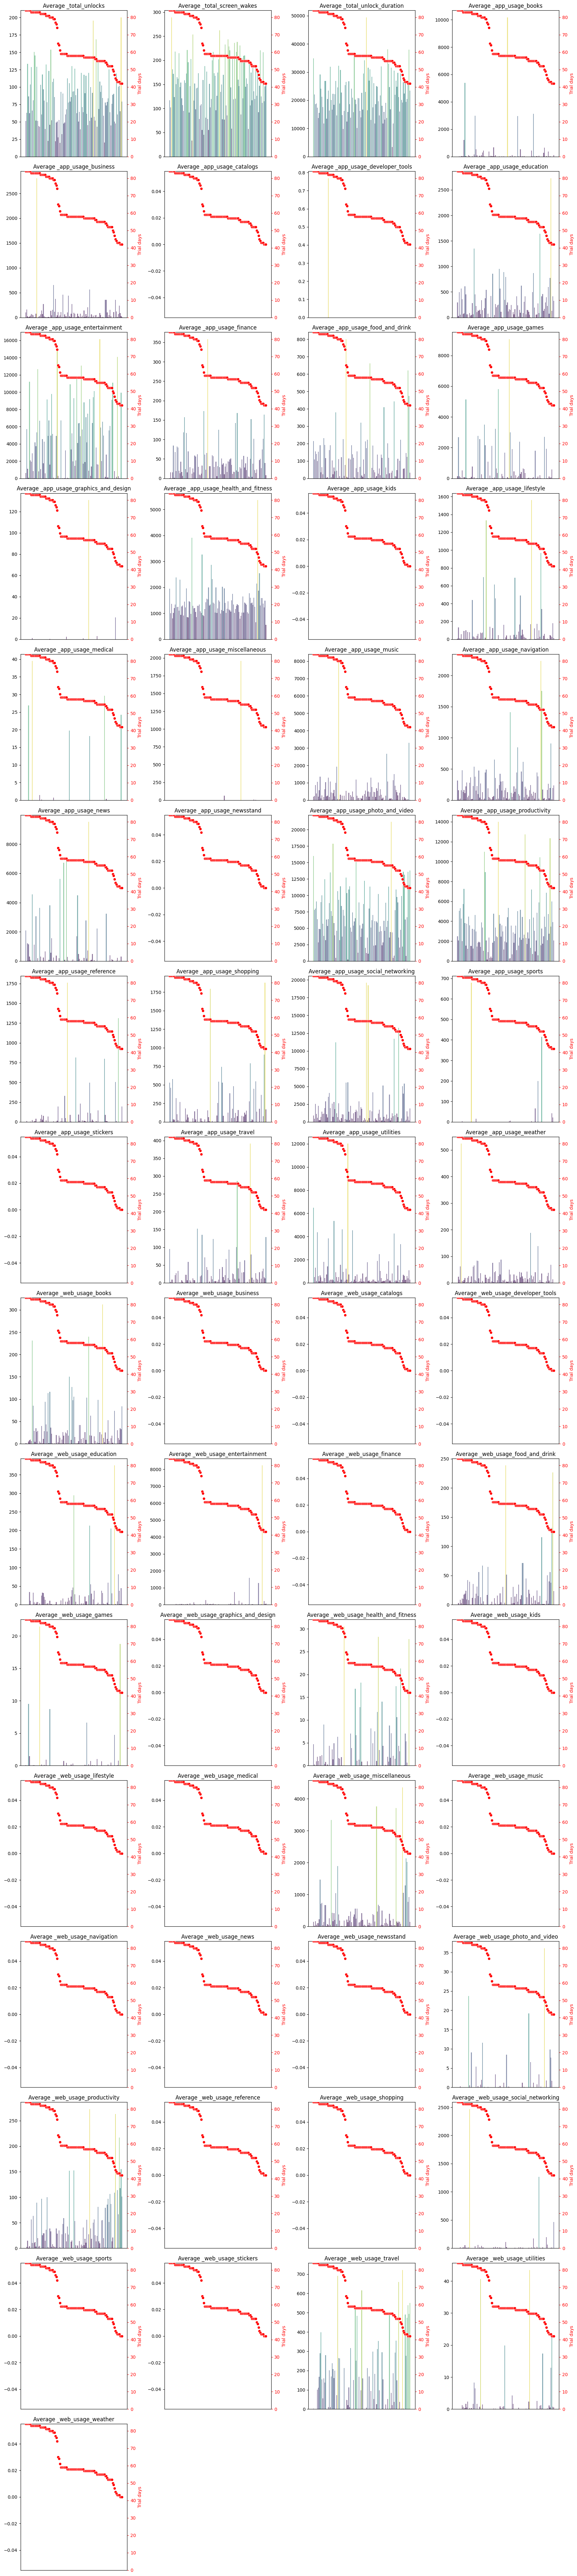

In [40]:
# Filtering columns for visualization based on non-NaN coverage
columns_to_visualize = [col for col in df.columns if '_sk_device_' in col]

# Create a figure to hold the subplots, adjusting for 4 plots per row
nrows = int(len(columns_to_visualize) / 4) + (len(columns_to_visualize) % 4 > 0)
fig, axes = plt.subplots(nrows, 4, figsize=(18, nrows * 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

for i, col in enumerate(columns_to_visualize):
    sorted_df = trial_days_by_pid.sort_values(by=col, ascending=False)
    sorted_pids = sorted_df['PID']
    sorted_metric_values = average_responses_by_pid.set_index('PID').loc[sorted_pids][col]
    
    # Normalize the metric values
    norm = plt.Normalize(sorted_metric_values.min(), sorted_metric_values.max())
    colors = cm.viridis(norm(sorted_metric_values.values))
    
    # Create twin axis for the second y-axis (Trial days)
    ax2 = axes[i].twinx()
    
    # Plotting the bar plot with the colored bars
    sns.barplot(x=sorted_metric_values.index, y=sorted_metric_values.values, ax=axes[i], palette=colors, alpha=0.6)
    
    trial_day_values = sorted_df[col].values
    sns.scatterplot(x=range(len(sorted_pids)), y=trial_day_values, ax=ax2, color="red", zorder=5)
    
    title_col = col.replace('passive_sk_device', '')
    axes[i].set_title(f'Average {title_col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticklabels([])
    axes[i].tick_params(axis='x', which='both', bottom=False)
    
    ax2.set_ylim(0, 84)
    ax2.set_ylabel('Trial days', color='red')
    ax2.tick_params(axis='y', colors='red')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

#### Categories

We create a composite column that combines `web` and `app` usage and then creates historgrams of the top 3 averages in each category just to make sure that high averages are not being driven by outliers. 
- Note that I looked at both `web` and `app` usage on their own in this way to check for clear outliers and there were not any.

In [62]:
# Combine columns
# Step 1: Identify relevant columns
web_usage_cols = [col for col in df.columns if col.startswith('passive_sk_device_web_usage_')]
app_usage_cols = [col for col in df.columns if col.startswith('passive_sk_device_app_usage_')]
all_relevant_cols = web_usage_cols + app_usage_cols

# Step 2: Identify unique categories by stripping the prefix and creating a set
categories = set(col.split('_')[-1] for col in all_relevant_cols)

# Sort categories in alphabetical order
sorted_categories = sorted(categories)

# Step 3: Sum columns by category and create new columns for each total usage, iterating in alphabetical order
for category in sorted_categories:
    # Construct column names for app and web usage
    app_col = f'passive_sk_device_app_usage_{category}'
    web_col = f'passive_sk_device_web_usage_{category}'
    total_col = f'passive_sk_device_total_usage_{category}'
    
    # Check if both columns exist in the DataFrame; if not, use what's available
    if app_col in df and web_col in df:
        df[total_col] = df[app_col].fillna(0) + df[web_col].fillna(0)
    elif app_col in df:
        df[total_col] = df[app_col]
    elif web_col in df:
        df[total_col] = df[web_col]


In [63]:
[col for col in df.columns if 'total_usage' in col]

['passive_sk_device_total_usage_books',
 'passive_sk_device_total_usage_business',
 'passive_sk_device_total_usage_catalogs',
 'passive_sk_device_total_usage_education',
 'passive_sk_device_total_usage_entertainment',
 'passive_sk_device_total_usage_finance',
 'passive_sk_device_total_usage_games',
 'passive_sk_device_total_usage_kids',
 'passive_sk_device_total_usage_lifestyle',
 'passive_sk_device_total_usage_medical',
 'passive_sk_device_total_usage_miscellaneous',
 'passive_sk_device_total_usage_music',
 'passive_sk_device_total_usage_navigation',
 'passive_sk_device_total_usage_news',
 'passive_sk_device_total_usage_newsstand',
 'passive_sk_device_total_usage_productivity',
 'passive_sk_device_total_usage_reference',
 'passive_sk_device_total_usage_shopping',
 'passive_sk_device_total_usage_sports',
 'passive_sk_device_total_usage_stickers',
 'passive_sk_device_total_usage_travel',
 'passive_sk_device_total_usage_utilities',
 'passive_sk_device_total_usage_weather']

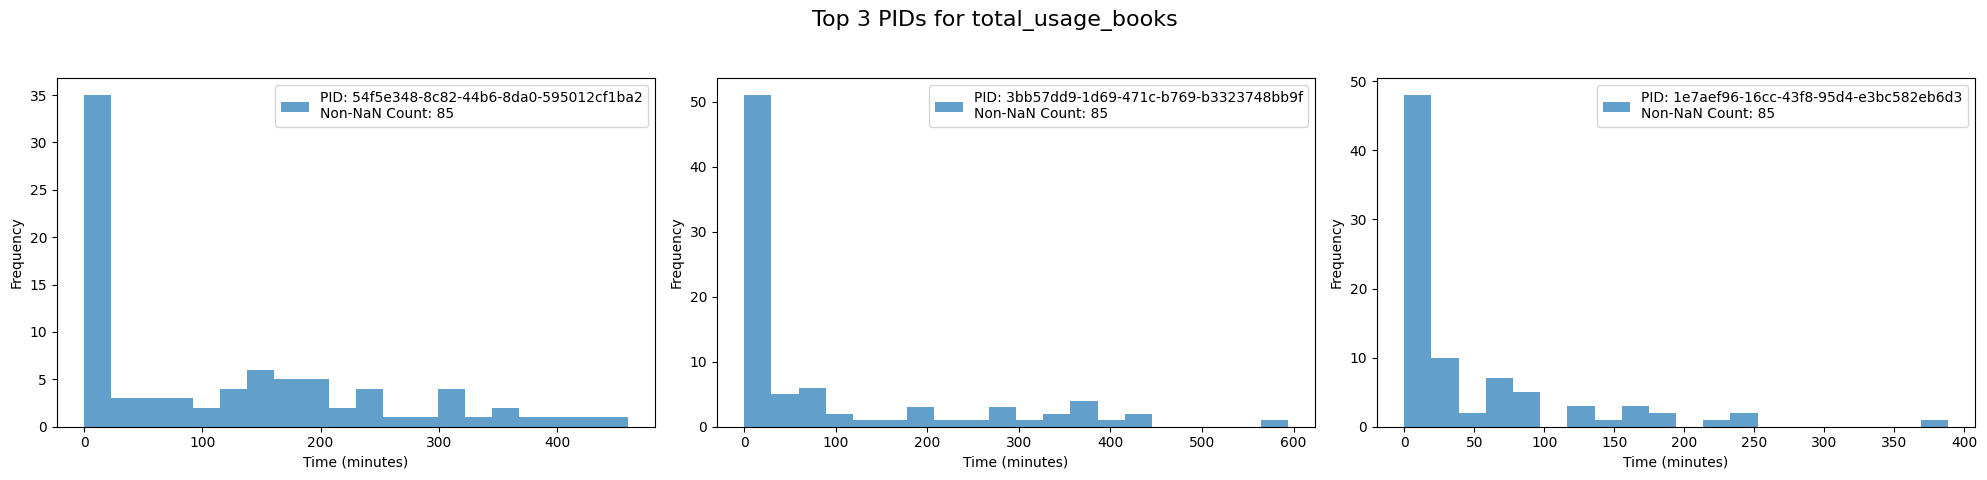

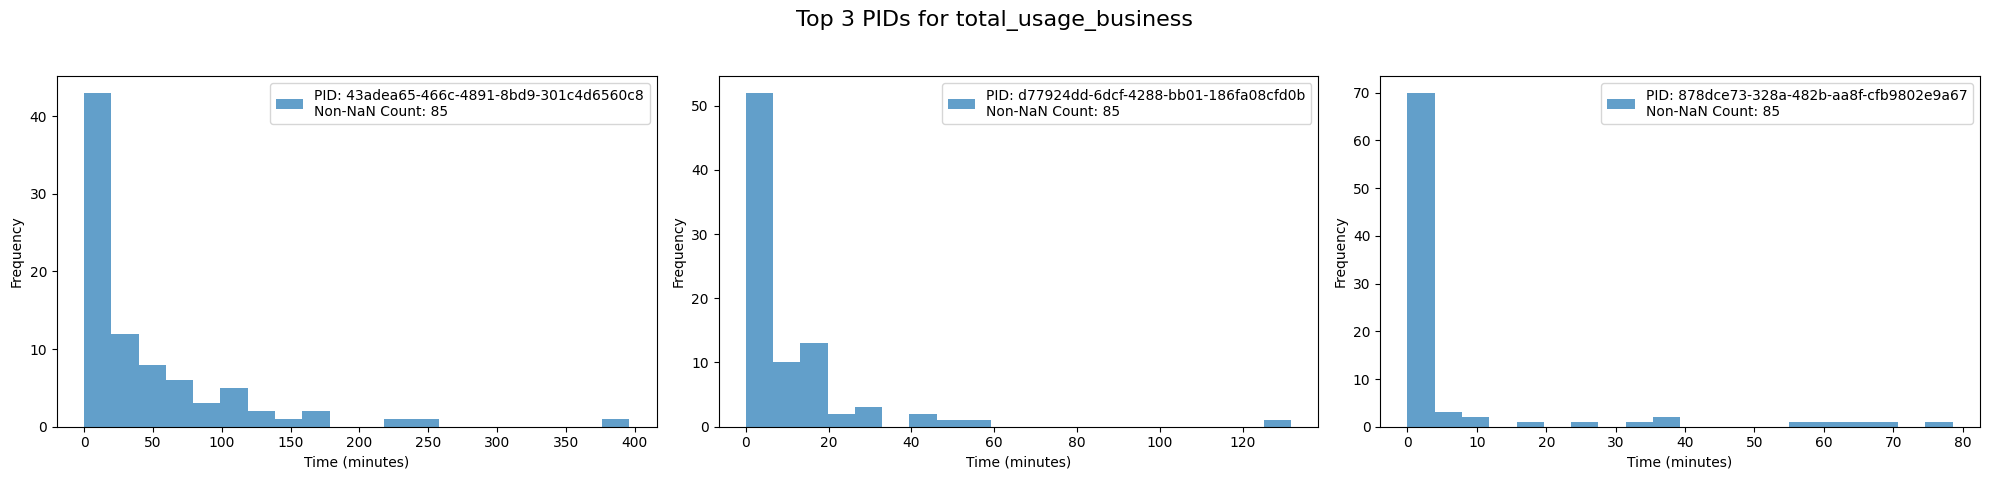

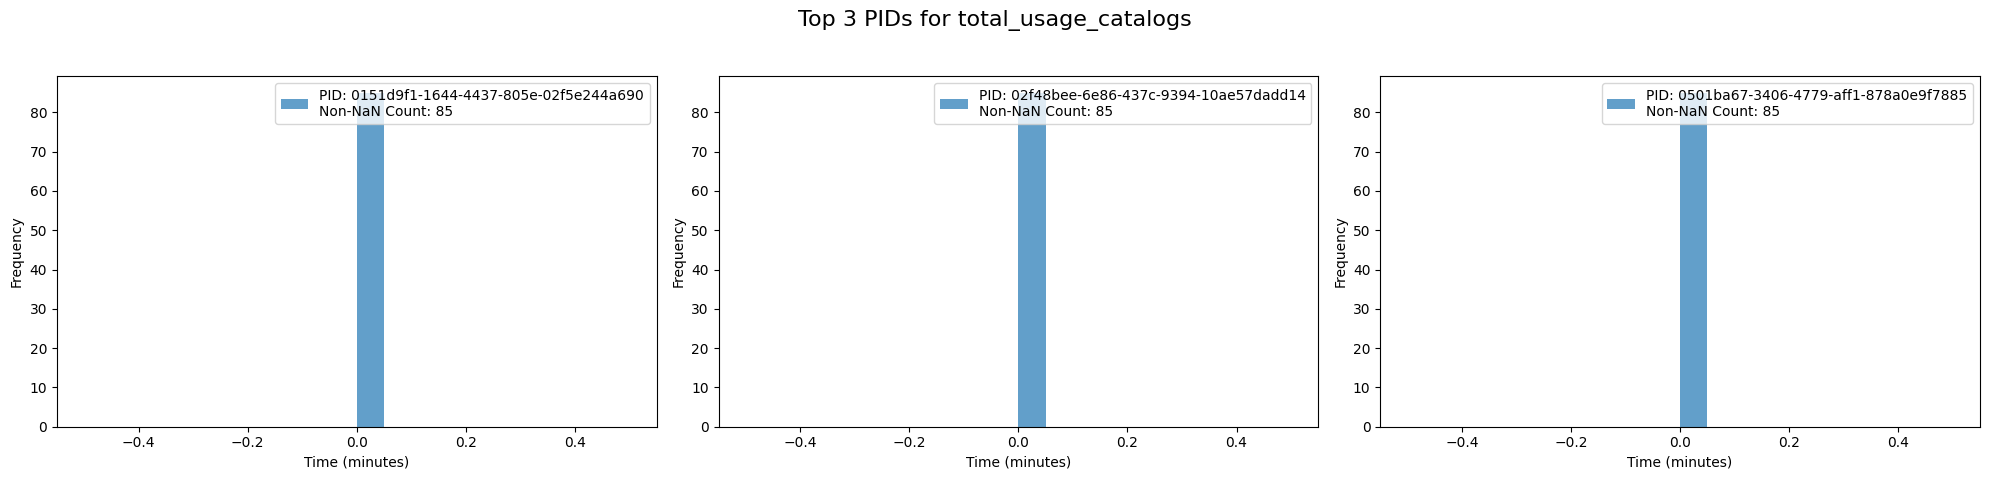

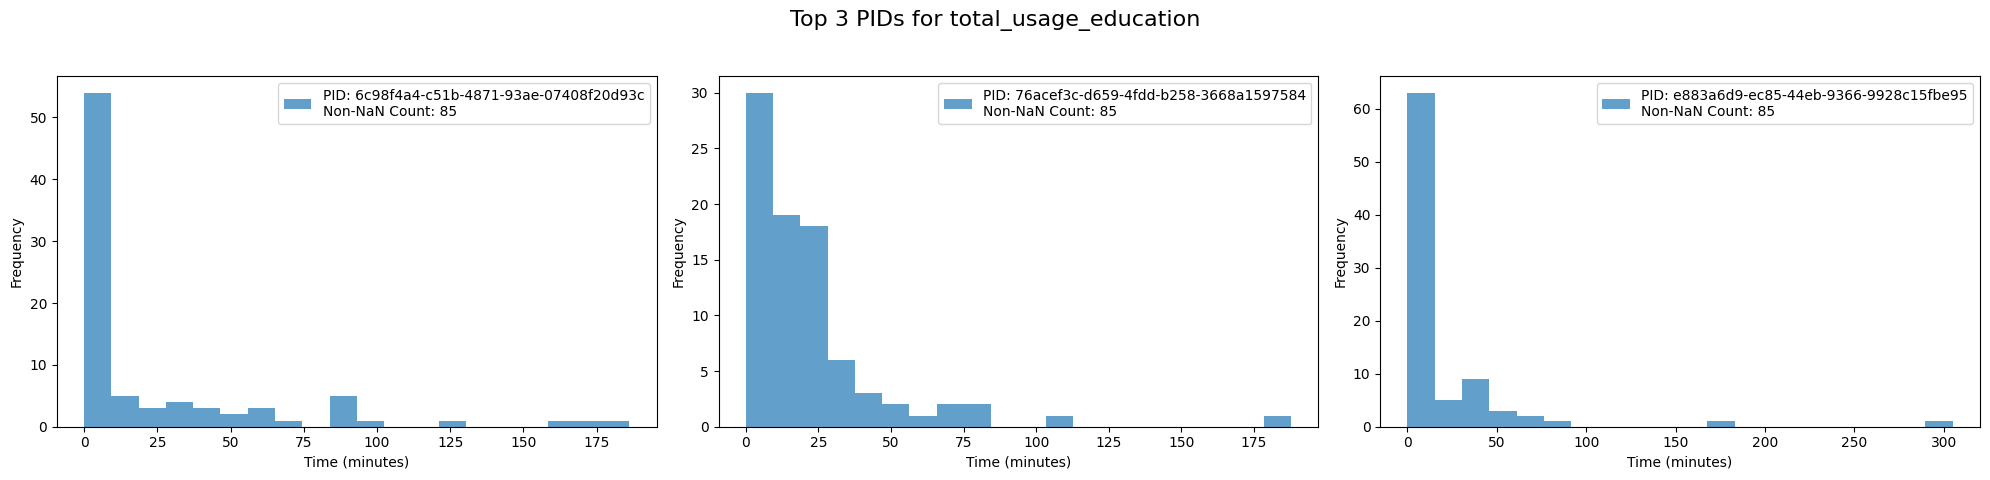

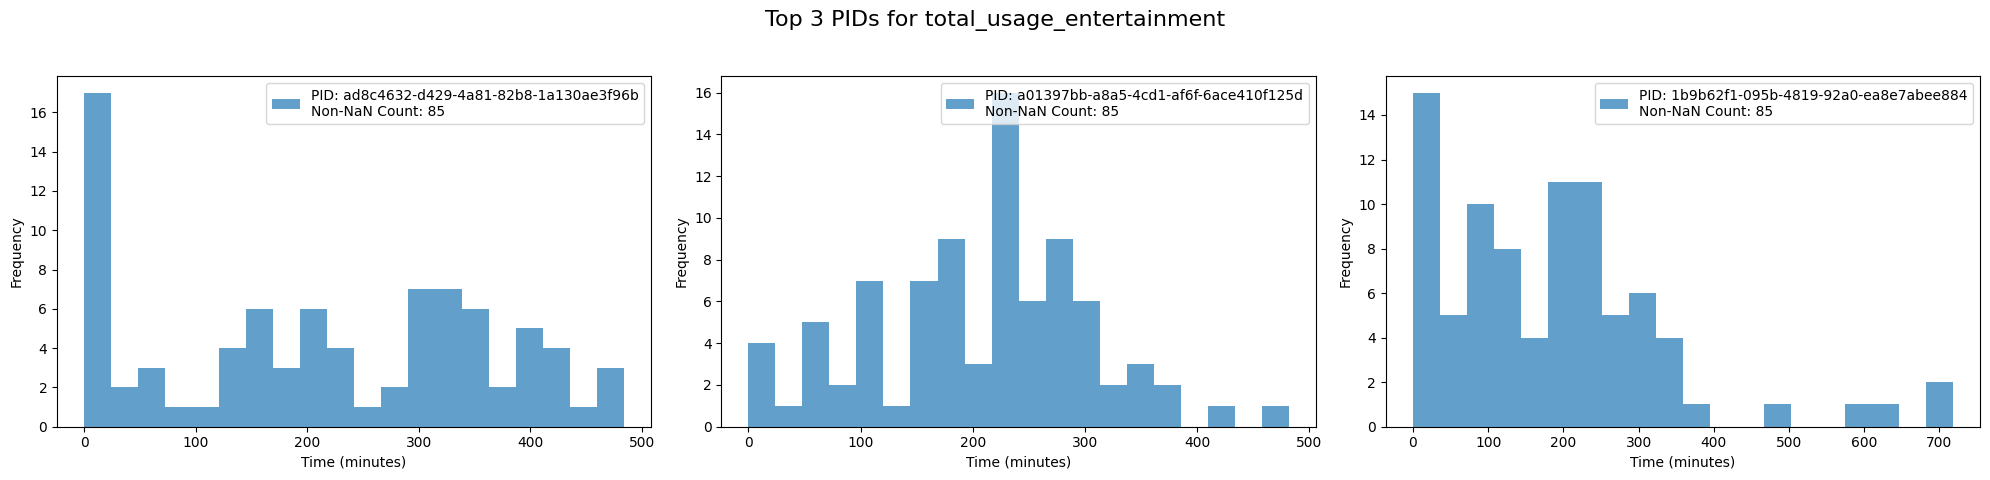

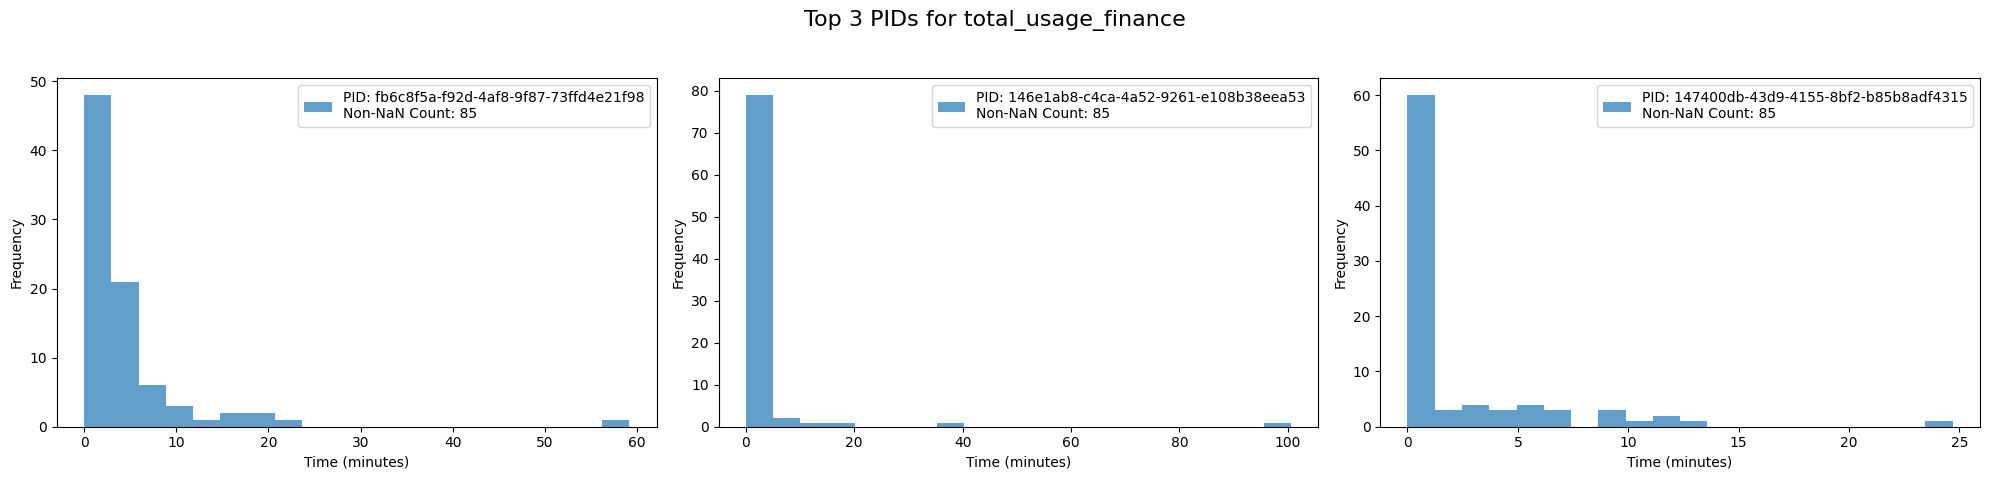

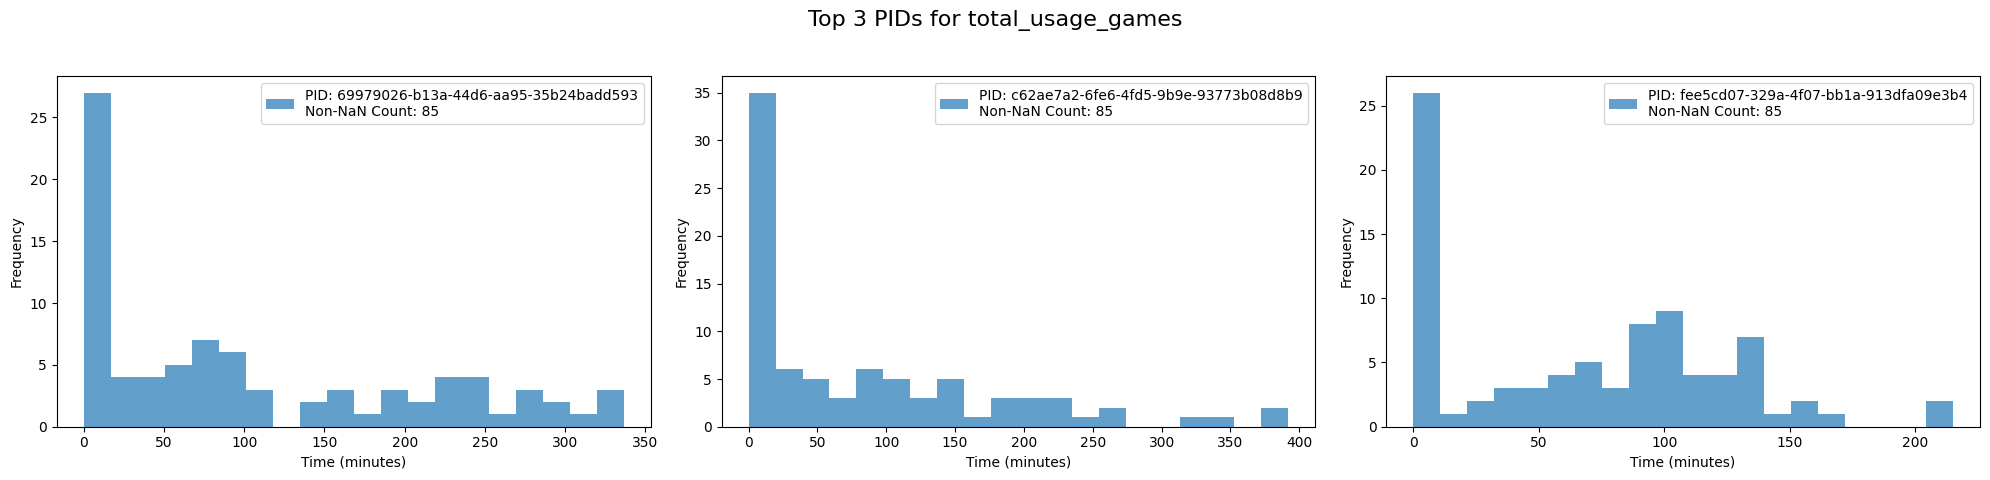

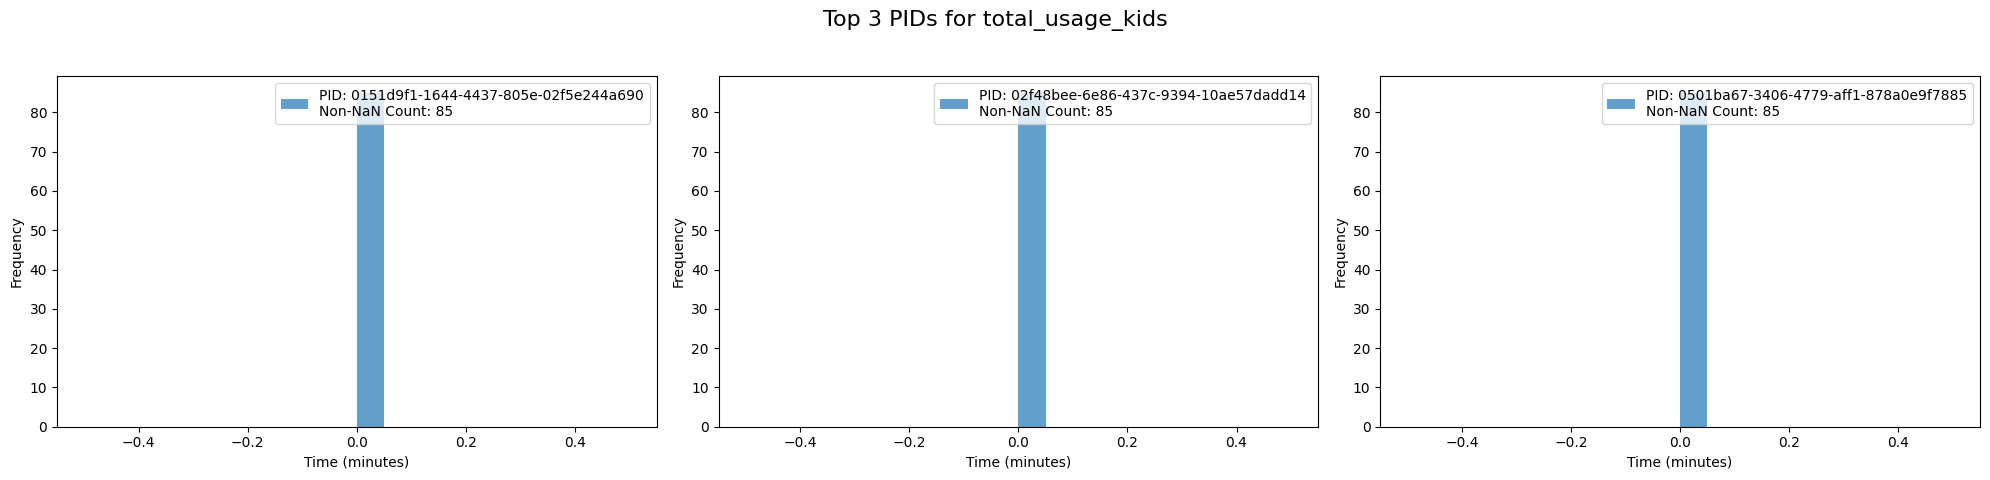

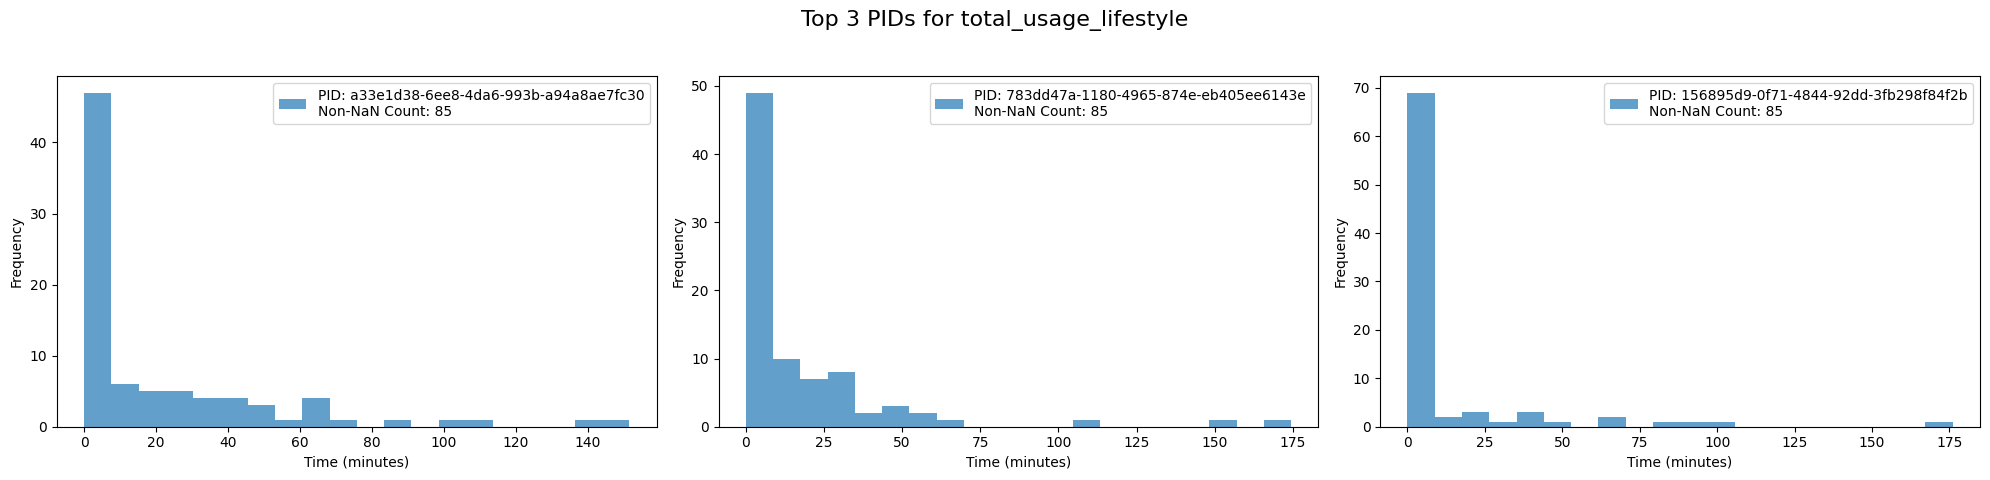

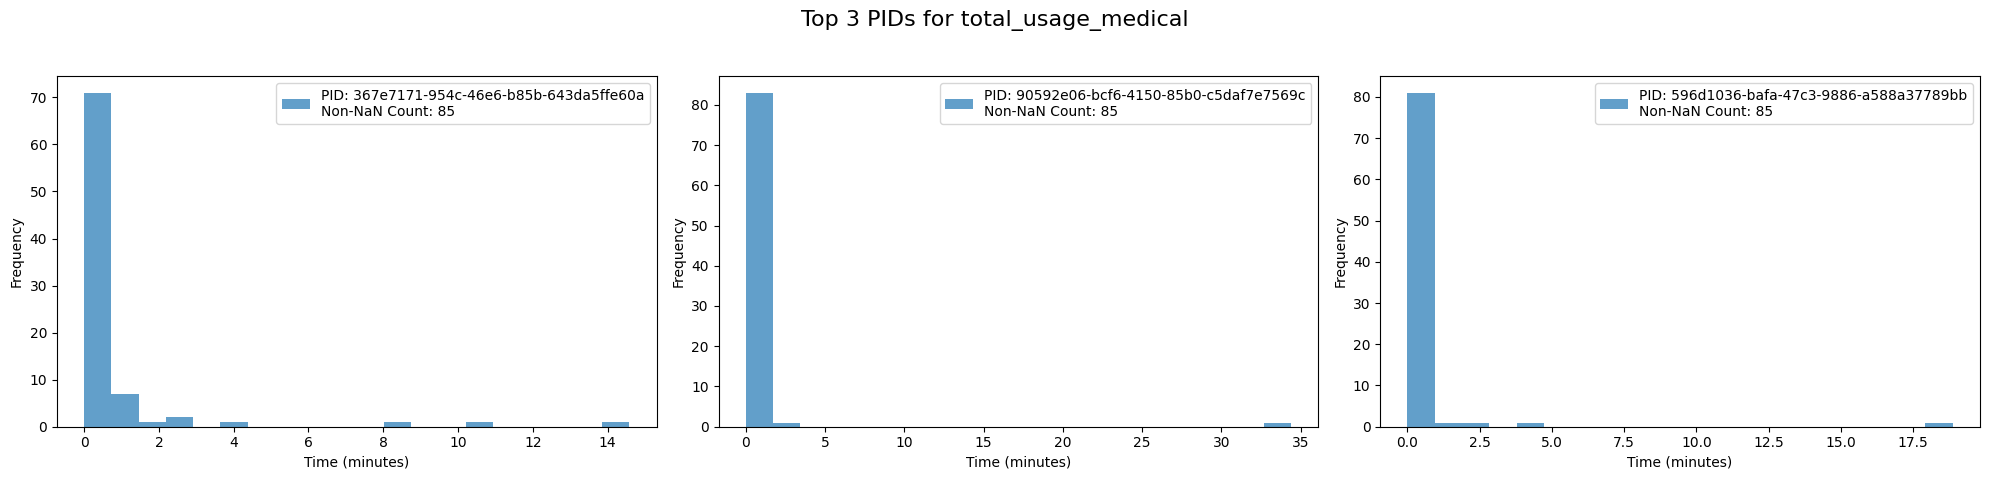

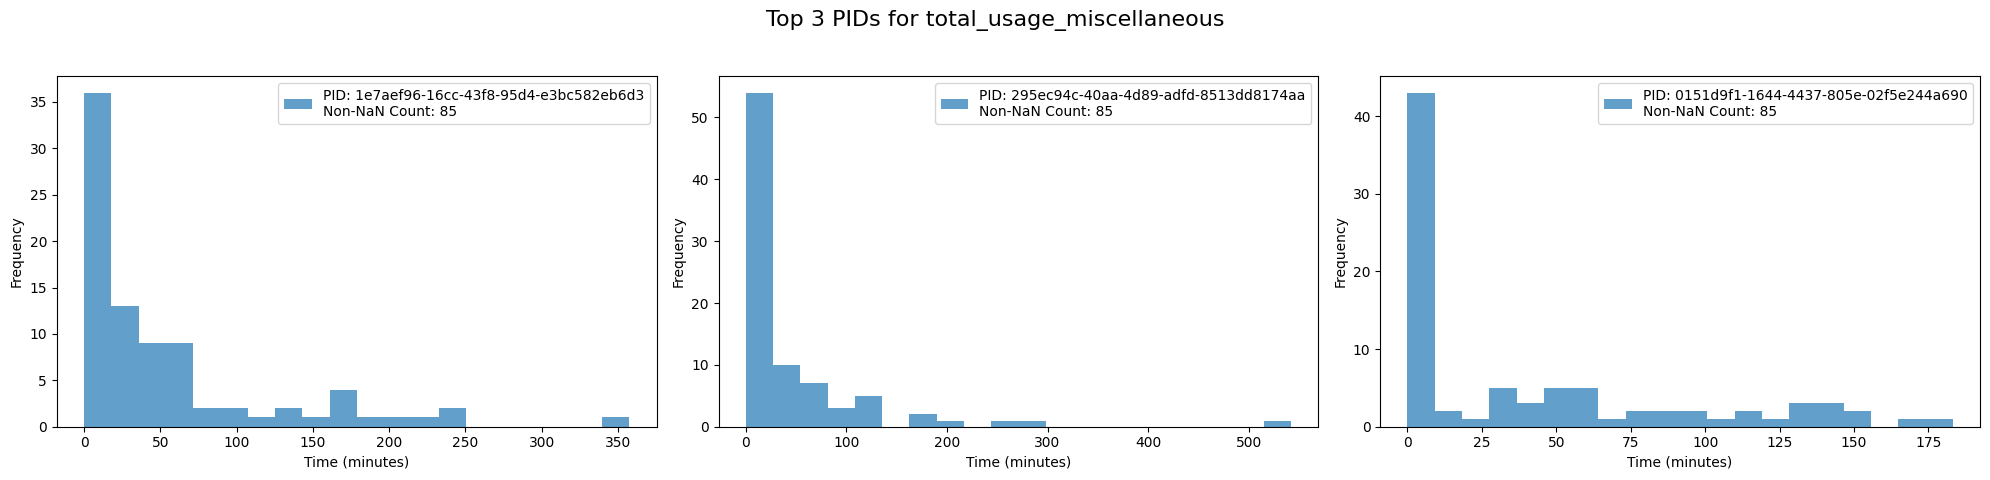

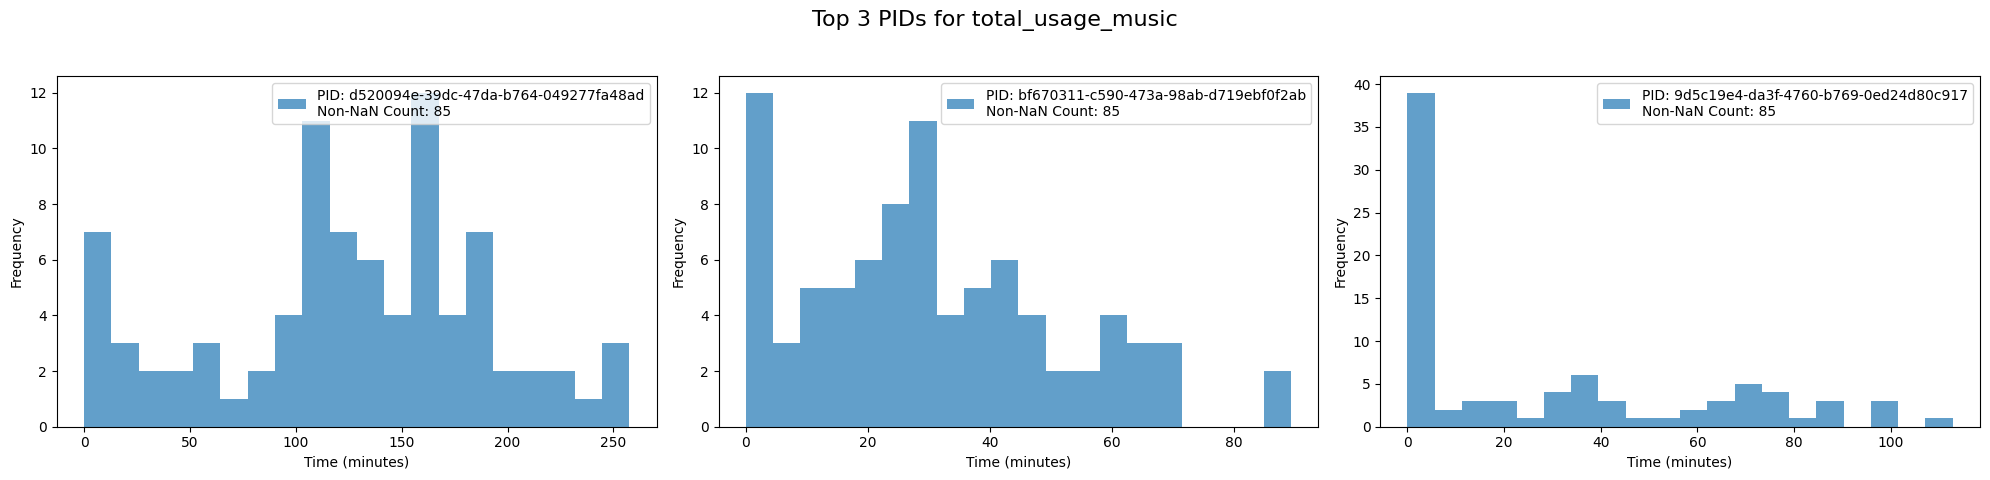

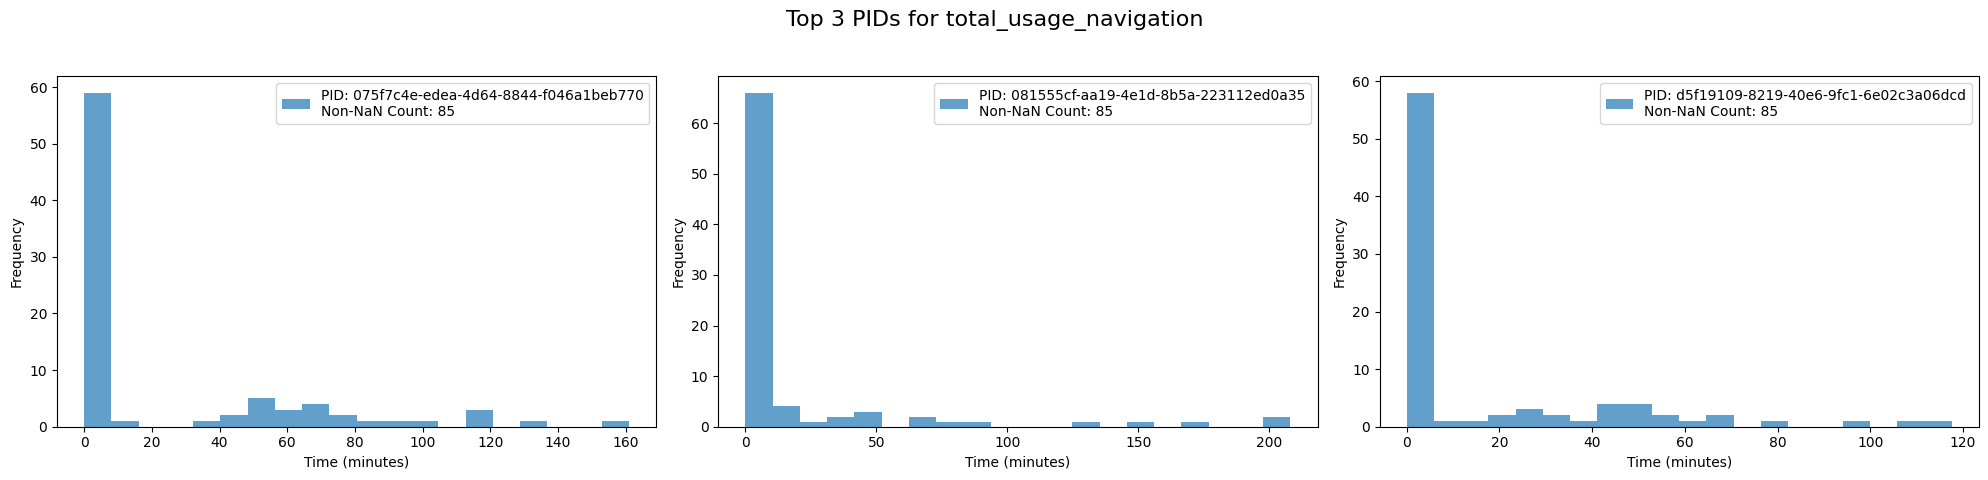

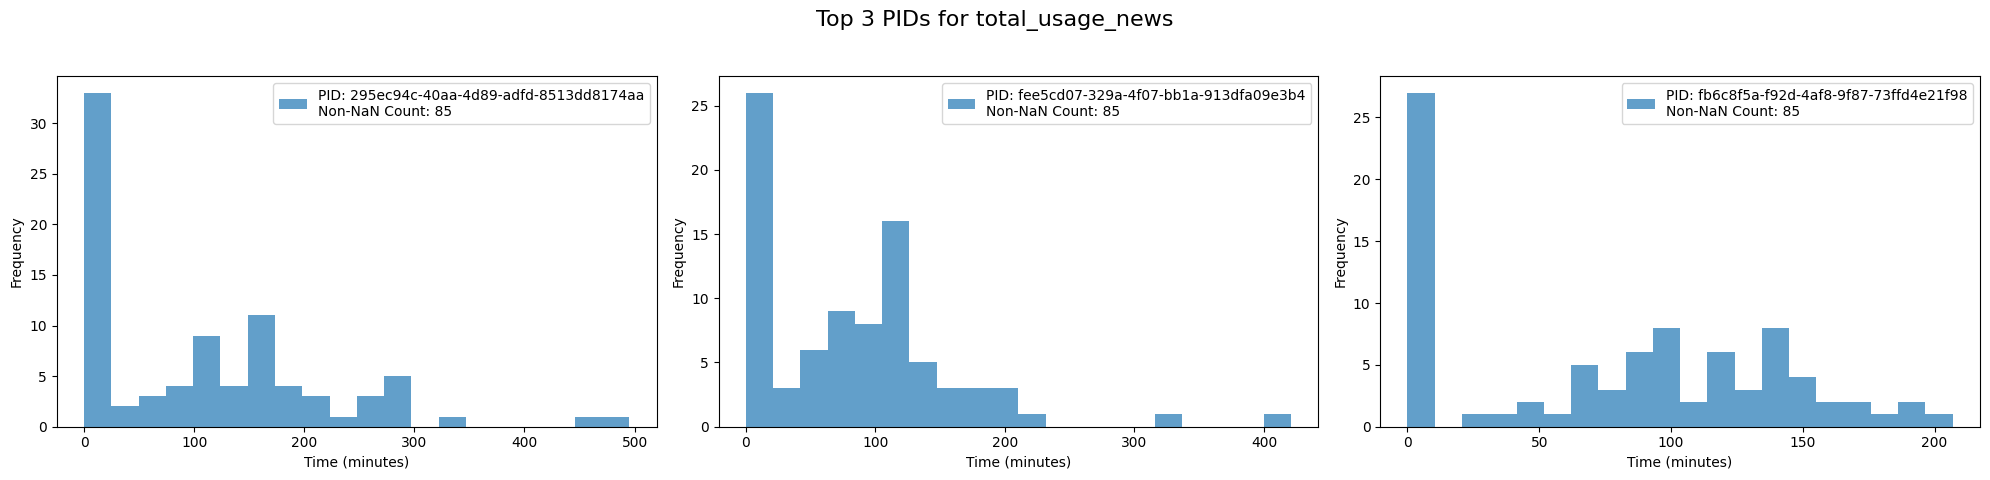

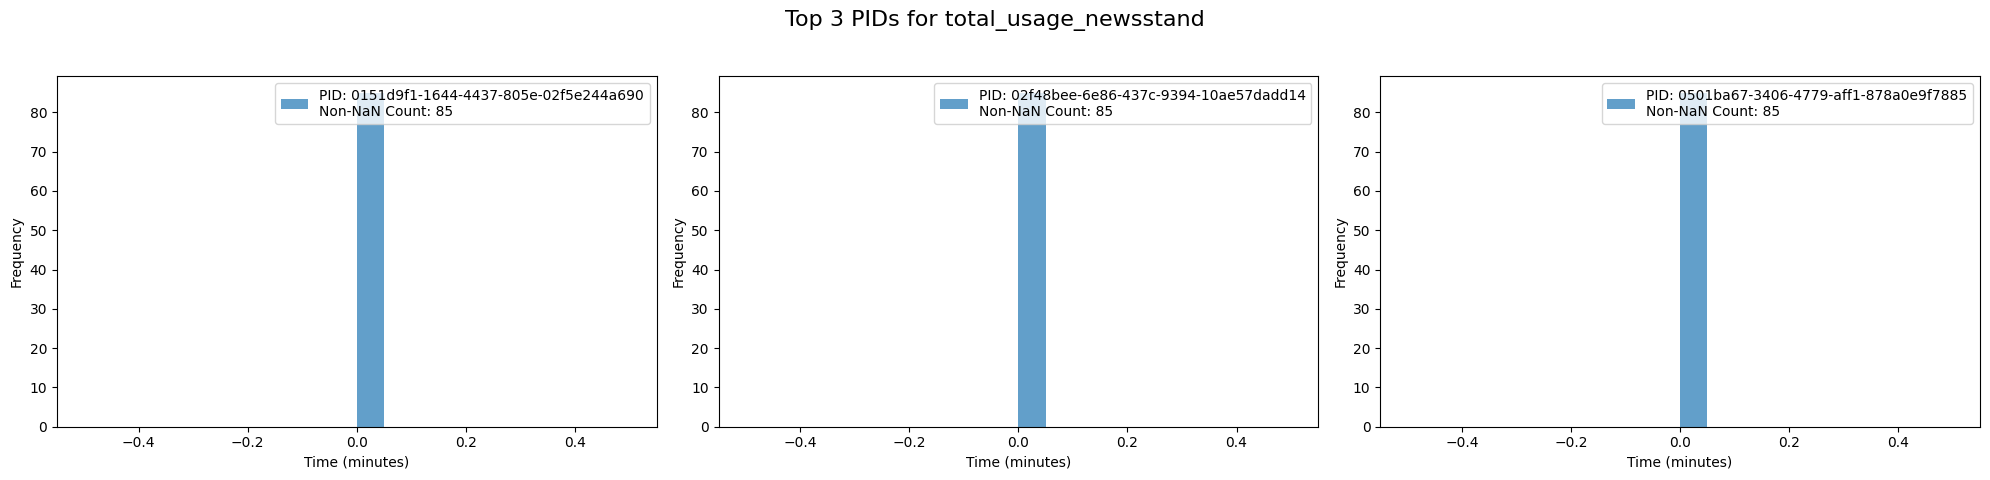

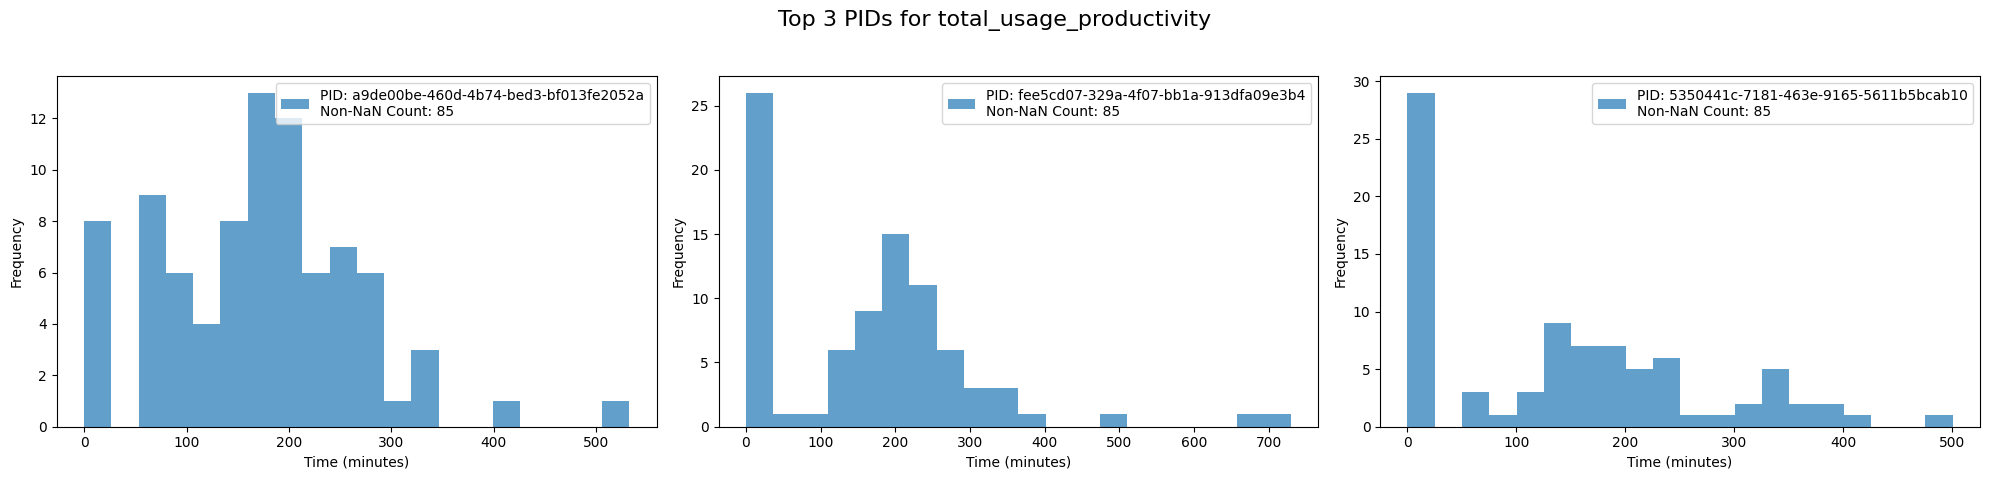

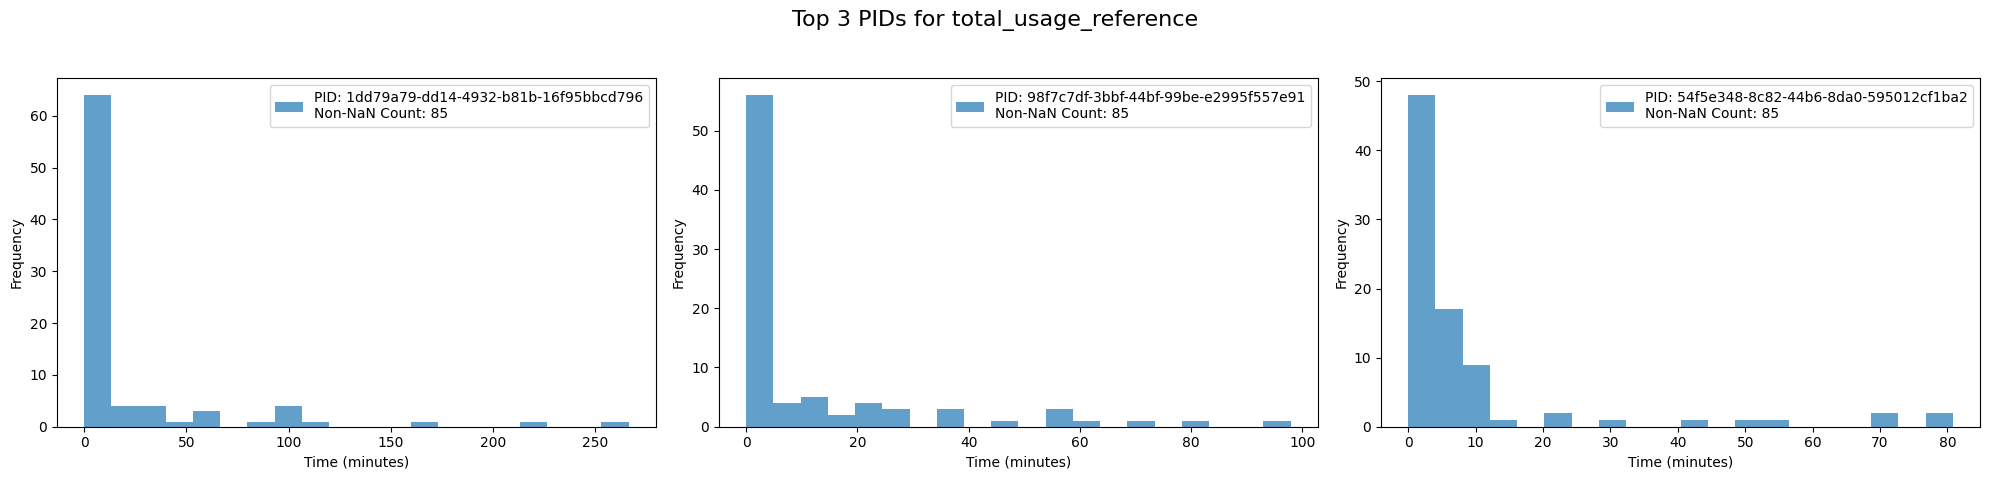

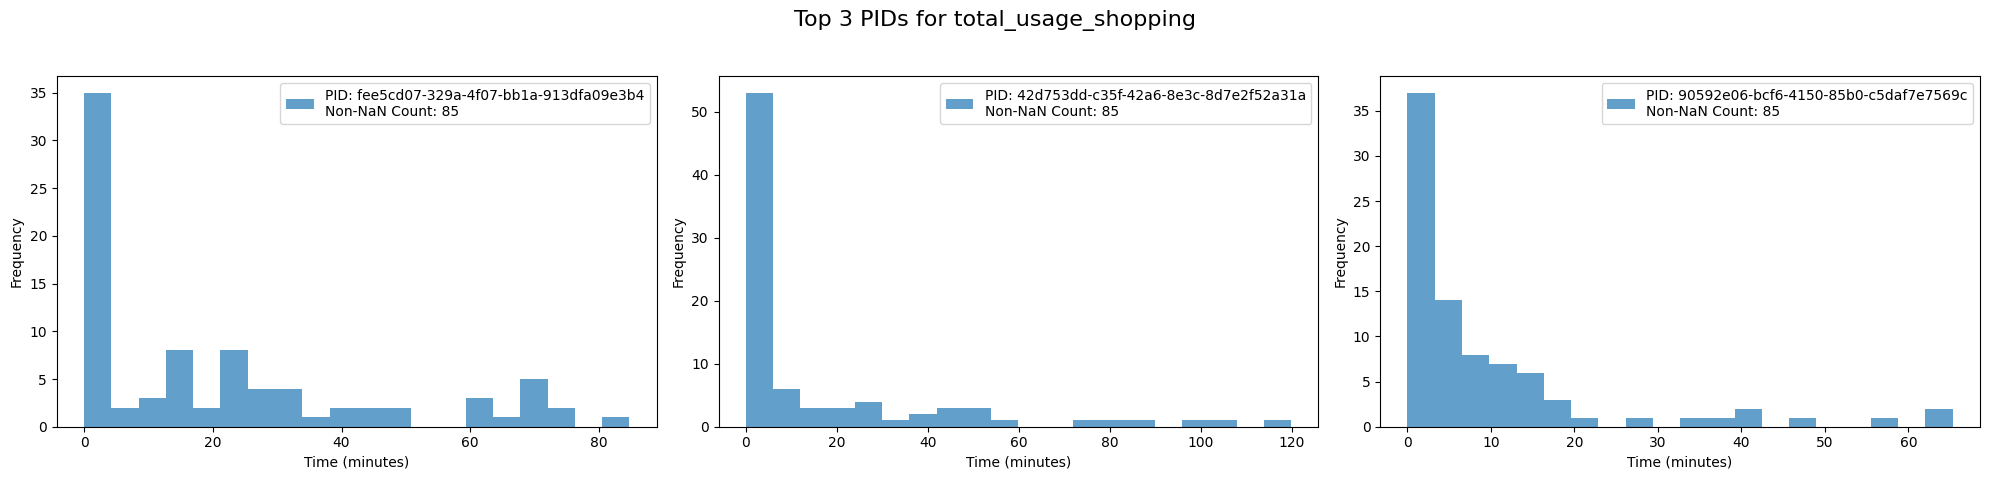

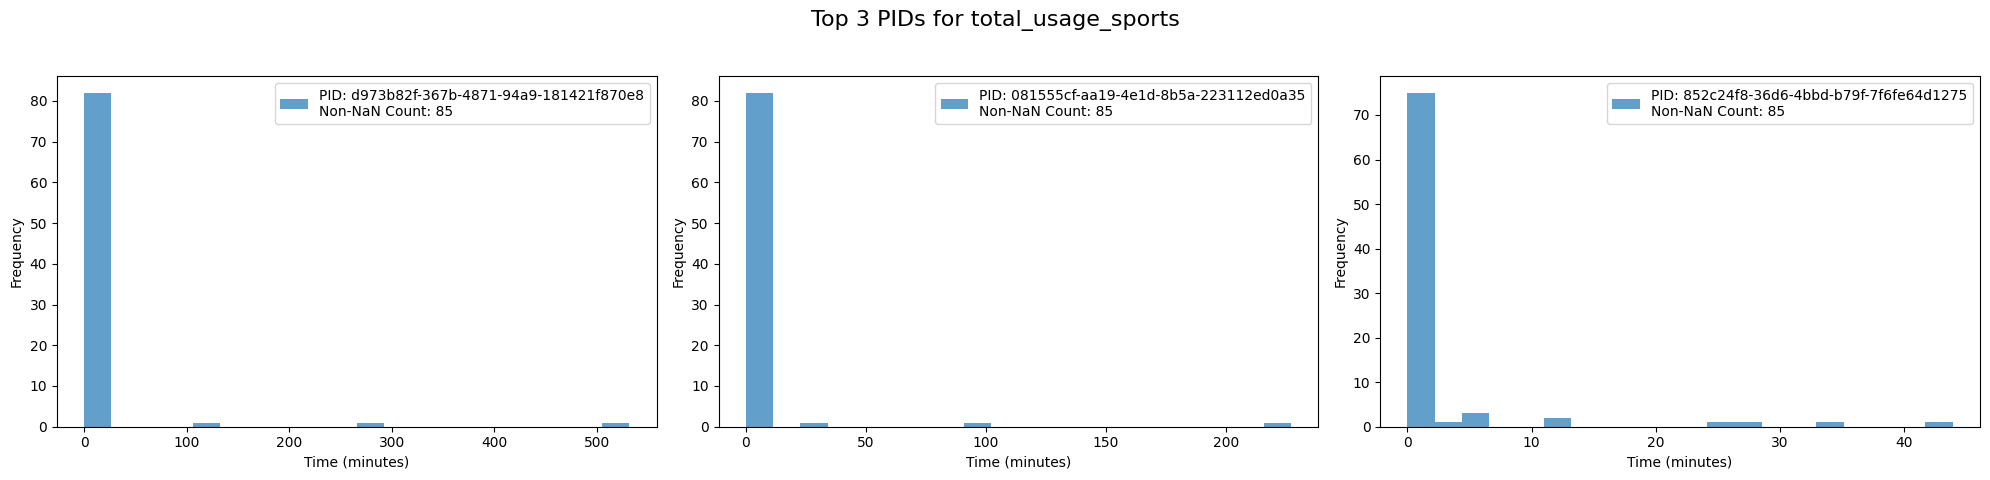

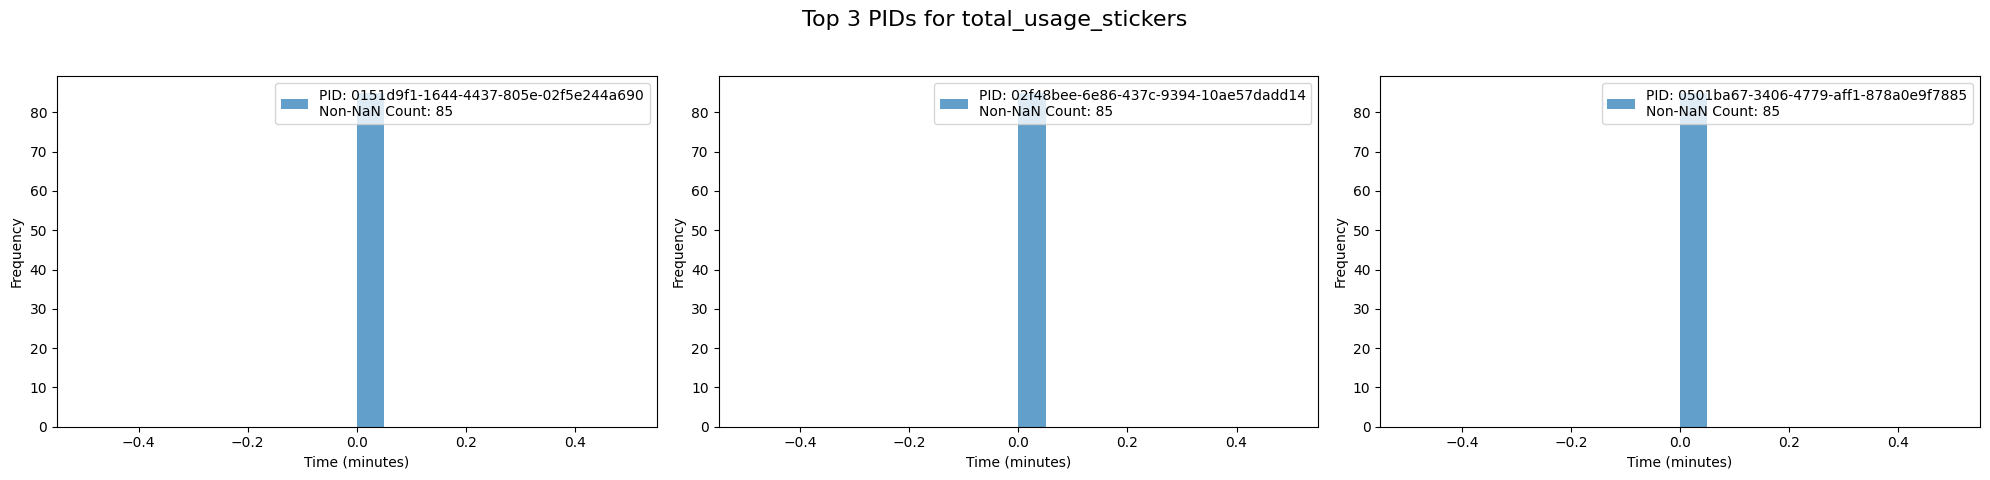

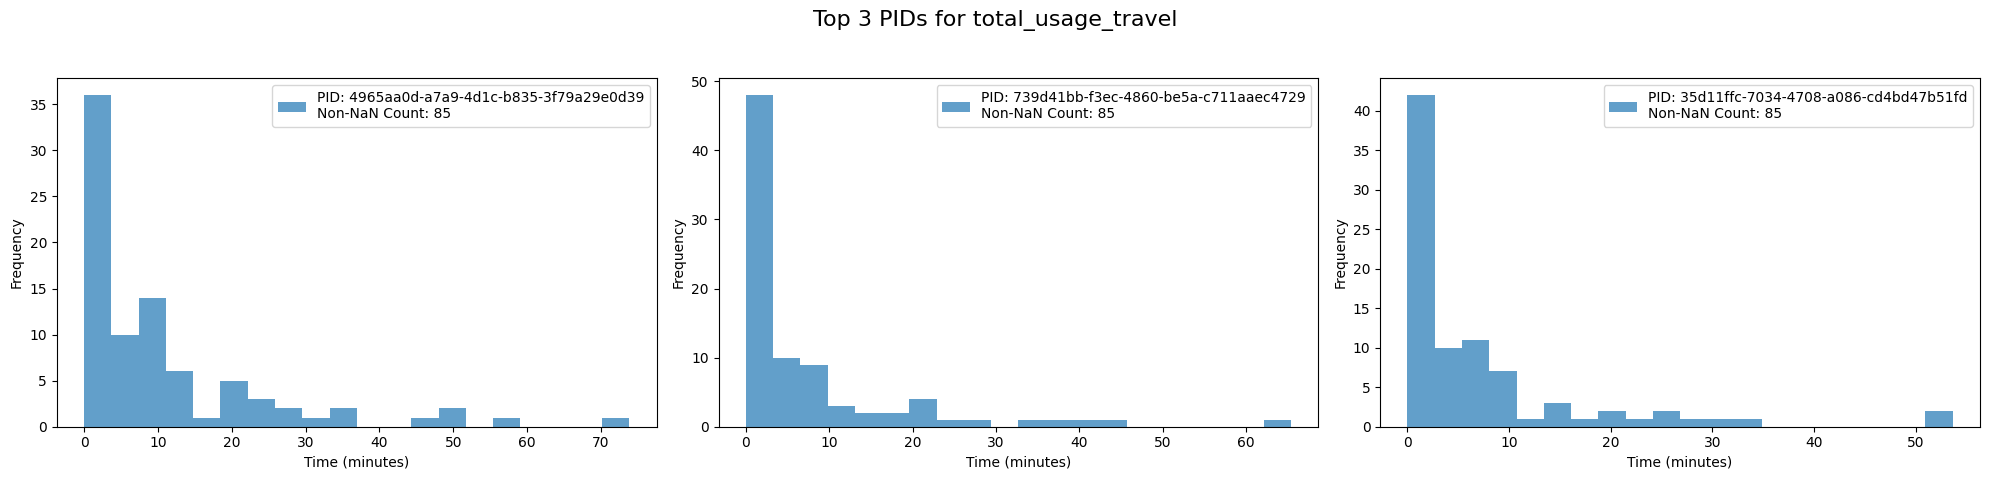

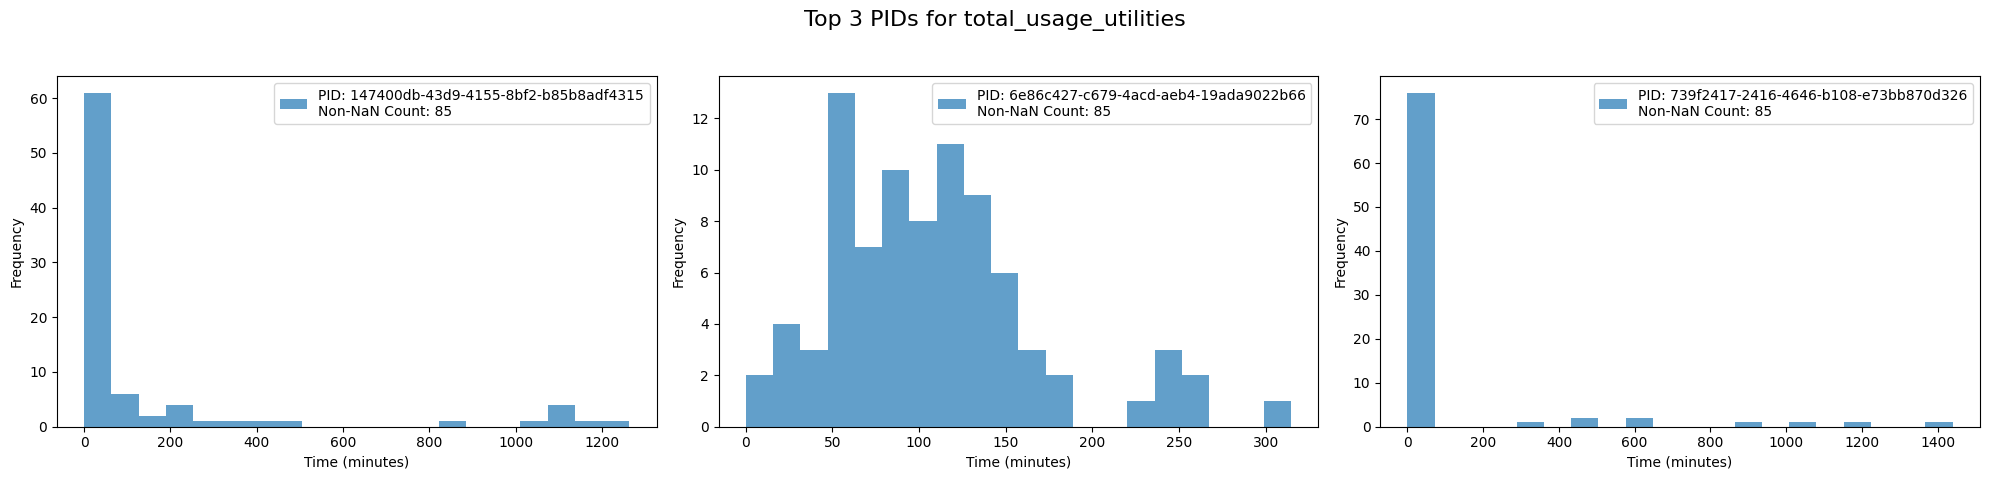

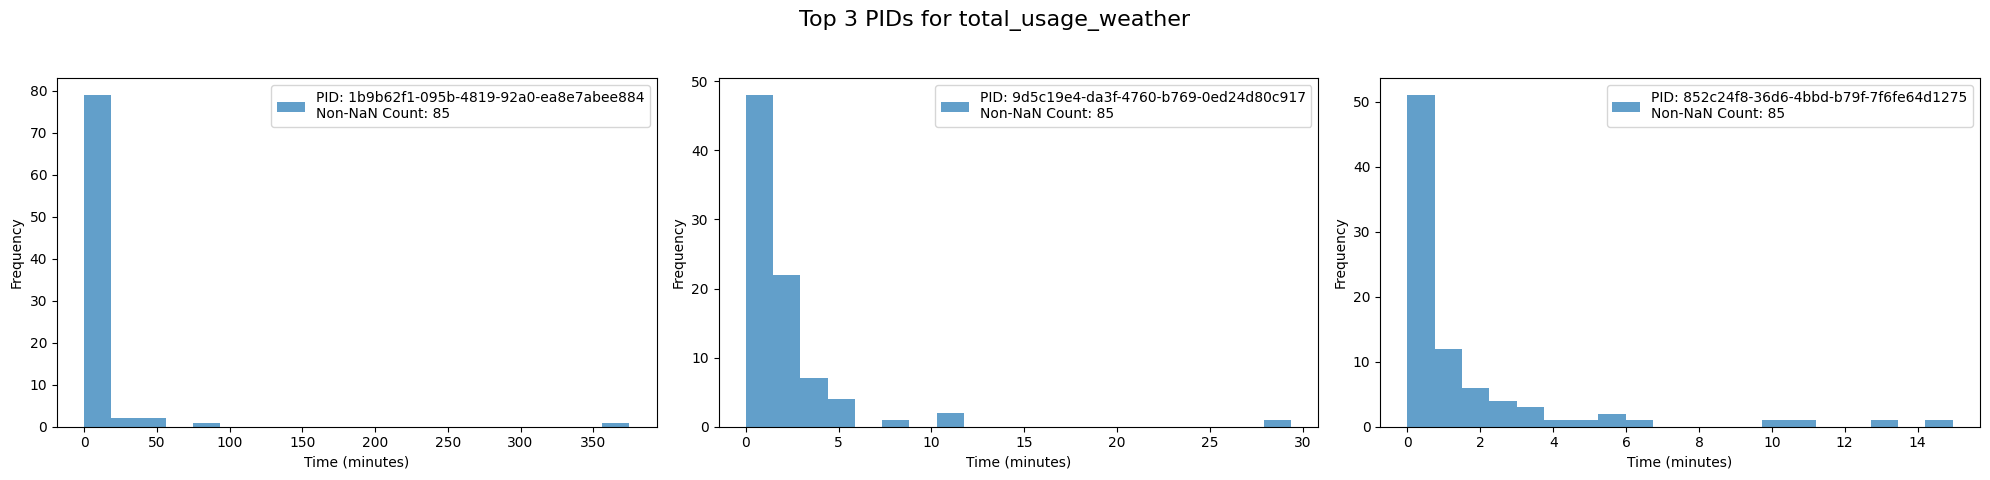

In [64]:
# Filter columns that start with 'passive_sk_device_app'
filtered_columns = [col for col in df.columns if col.startswith('passive_sk_device_total_usage')]
df_filtered = df[['PID'] + filtered_columns]

# Group by PID and calculate averages
df_grouped_avg = df_filtered.groupby('PID').mean()

# Process each filtered column
for col in filtered_columns:
    # Select the top three PIDs based on the average values
    top_pids = df_grouped_avg[col].nlargest(3).index

    # Prepare a single row of subplots for the top three PIDs
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    col_name = col.replace('passive_sk_device_', '')
    fig.suptitle(f'Top 3 PIDs for {col_name}', fontsize=16)
    
    for i, pid in enumerate(top_pids):
        # Filter data for the current PID and column
        pid_data = df_filtered[df_filtered['PID'] == pid][col]
        
        # Count non-NaN values
        non_nan_count = pid_data.notna().sum()
        
        # Plot histogram
        axes[i].hist(pid_data.dropna()/60, bins=20, alpha=0.7, label=f'PID: {pid}\nNon-NaN Count: {non_nan_count}')
        axes[i].set_xlabel('Time (minutes)')
        axes[i].set_ylabel('Frequency')
        axes[i].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the global title
    plt.show()

In [77]:
# Do those people who on average consume for than 5 minutes of news per day feel happier on days when they do NOT consume news?

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Compute average 'passive_sk_device_total_usage_news' by PID
avg_usage_by_pid = df.groupby('PID')['passive_sk_device_total_usage_news'].mean()

# Filter PIDs with an average greater than 300
filtered_pids = avg_usage_by_pid[avg_usage_by_pid > 300].index

# Filter the DataFrame to include only the selected PIDs
df_filtered = df[df['PID'].isin(filtered_pids)]

# Dummy code 'passive_sk_device_total_usage_news': 0 if value is 0, 1 if non-zero
df_filtered['news_usage_dummy'] = df_filtered['passive_sk_device_total_usage_news'].apply(lambda x: 1 if x > 0 else 0)

# Ensure the 'PID' column is treated as a categorical variable for grouping
df_filtered['PID'] = df_filtered['PID'].astype('category')

# Reset the index of df_filtered
df_filtered.reset_index(drop=True, inplace=True)

# Dropping rows where 'sr_affect_net_avg' is NaN
df_filtered_clean = df_filtered.dropna(subset=['sr_affect_net_avg'])

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_87757/451470214.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['news_usage_dummy'] = df_filtered['passive_sk_device_total_usage_news'].apply(lambda x: 1 if x > 0 else 0)
/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_87757/451470214.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['PID'] = df_filtered['PID'].astype('category')


In [78]:
# Using PID as a group-level identifier for nesting

# Dropping rows where 'sr_affect_net_avg' is NaN
df_filtered_clean = df_filtered.dropna(subset=['sr_affect_net_avg'])

# Fitting the model again with the cleaned DataFrame
model_clean = smf.mixedlm("sr_affect_net_avg ~ news_usage_dummy", df_filtered_clean, groups=df_filtered_clean["PID"])
result_clean = model_clean.fit()

# Print the summary of the cleaned model
result_clean.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:            MixedLM Dependent Variable: sr_affect_net_avg
No. Observations: 1855    Method:             REML             
No. Groups:       25      Scale:              0.5646           
Min. group size:  43      Log-Likelihood:     -2166.1908       
Max. group size:  84      Converged:          Yes              
Mean group size:  74.2                                         
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          0.228     0.215  1.061  0.289  -0.193   0.649
news_usage_dummy   0.064     0.044  1.449  0.147  -0.022   0.150
Group Var          1.118     0.435                              
===============================================================

"""

In [86]:
# Dropping rows where 'sr_affect_net_avg' is NaN
df_filtered_clean = df_filtered.dropna(subset=['sr_affect_net_avg'])
df_filtered_clean = df_filtered_clean[df_filtered_clean.passive_sk_device_total_usage_news>0]
df_filtered_clean = df_filtered_clean[df_filtered_clean.passive_sk_device_total_usage_news<10000]

# Fitting the model again with the cleaned DataFrame
model_clean = smf.mixedlm("sr_affect_net_avg ~ passive_sk_device_total_usage_news", df_filtered_clean, groups=df_filtered_clean["PID"])
result_clean = model_clean.fit()

# Print the summary of the cleaned model
result_clean.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Mixed Linear Model Regression Results
=============================================================================
Model:                  MixedLM     Dependent Variable:     sr_affect_net_avg
No. Observations:       1309        Method:                 REML             
No. Groups:             25          Scale:                  0.5875           
Min. group size:        21          Log-Likelihood:         -1575.5885       
Max. group size:        82          Converged:              Yes              
Mean group size:        52.4                                                 
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.328    0.209  1.569 0.117 -0.082  0.737
passive_sk_device_total_usage_news -0.000    0.000 -1.211 0.226 -0.000  0.000
Group Var                           1.049    0.404                           
=============================================================================

"""

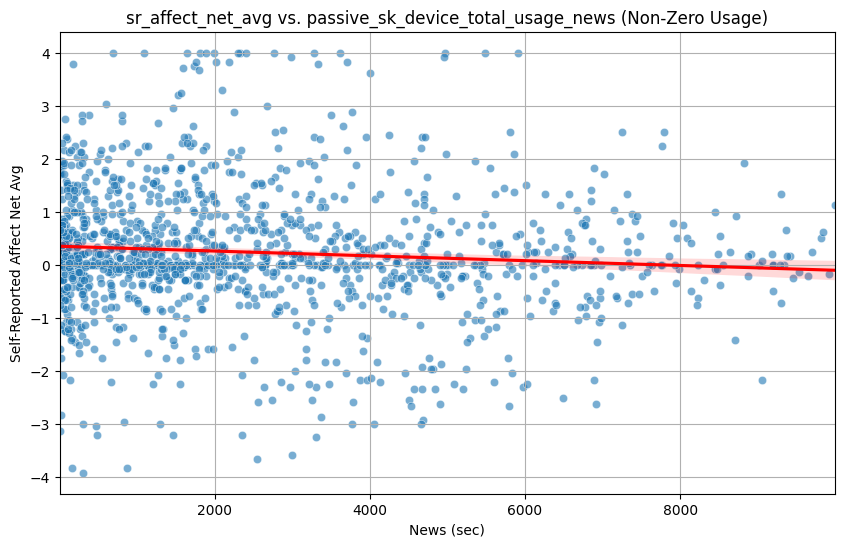

In [85]:
df_filtered_clean = df_filtered_clean[df_filtered_clean.passive_sk_device_total_usage_news>0]
df_filtered_clean = df_filtered_clean[df_filtered_clean.passive_sk_device_total_usage_news<10000]

plot_data = df_filtered_clean[['sr_affect_net_avg', 'passive_sk_device_total_usage_news']]

# Plotting sr_affect_net_avg vs. passive_sk_device_total_usage_news with a best fit line
plt.figure(figsize=(10, 6))

# Scatter plot of the non-zero news usage data
sns.scatterplot(x='passive_sk_device_total_usage_news', y='sr_affect_net_avg', data=plot_data, alpha=0.6)

# Fit a regression line to the data
sns.regplot(x='passive_sk_device_total_usage_news', y='sr_affect_net_avg', data=plot_data, scatter=False, color='red')

plt.title('sr_affect_net_avg vs. passive_sk_device_total_usage_news (Non-Zero Usage)')
plt.xlabel('News (sec)')
plt.ylabel('Self-Reported Affect Net Avg')
plt.grid(True)
plt.show()

In [106]:
correlations.sort_values()

PID
2262249f-9158-4ba1-9555-fa961d86e92e   -0.451202
dfef360e-27cb-4d35-bb4a-d6633803eb96   -0.433324
0a06ff99-9b73-4f6a-8b36-cdf27b4c22fd   -0.366419
117f2d92-eb60-4ed8-a99d-08ddbb775655   -0.225469
295ec94c-40aa-4d89-adfd-8513dd8174aa   -0.216091
d5f19109-8219-40e6-9fc1-6e02c3a06dcd   -0.184103
63f4637d-9f05-4561-8995-667470be3c7c   -0.168112
fed3a16b-c5a3-4a84-a111-32b7574e04b5   -0.092668
fb6c8f5a-f92d-4af8-9f87-73ffd4e21f98   -0.045478
c2bfc053-7c57-4ec9-aa69-2fcba2aaba5d   -0.043959
147400db-43d9-4155-8bf2-b85b8adf4315   -0.039801
90592e06-bcf6-4150-85b0-c5daf7e7569c   -0.030777
69979026-b13a-44d6-aa95-35b24badd593   -0.026752
156895d9-0f71-4844-92dd-3fb298f84f2b   -0.022017
1b9b62f1-095b-4819-92a0-ea8e7abee884    0.040147
d973b82f-367b-4871-94a9-181421f870e8    0.063224
6e86c427-c679-4acd-aeb4-19ada9022b66    0.070573
02f48bee-6e86-437c-9394-10ae57dadd14    0.083903
f8f71506-9382-40c7-99db-5c170b2a9abb    0.084617
fee5cd07-329a-4f07-bb1a-913dfa09e3b4    0.090332
852c24f8-36d6-4b

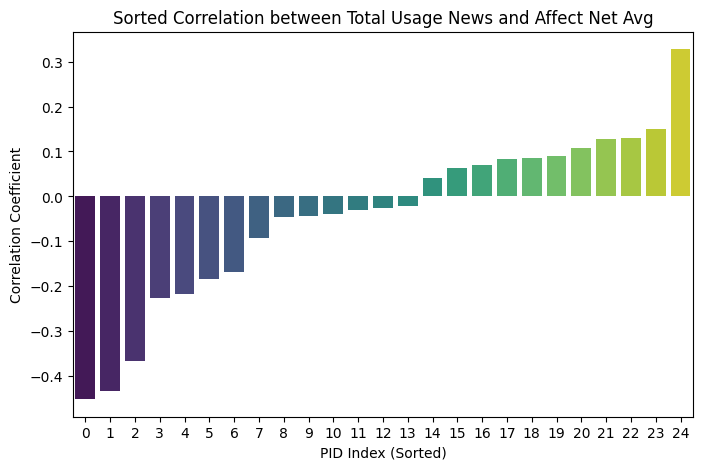

In [107]:
# Calculate the correlation between 'passive_sk_device_total_usage_news' and 'sr_affect_net_avg' for each PID
correlations = df_filtered_clean.groupby('PID').apply(lambda x: x['passive_sk_device_total_usage_news'].corr(x['sr_affect_net_avg']))

# Sorting the correlation values from smallest to largest explicitly
correlations_sorted_values = correlations.sort_values().values

# Creating an index for sorted correlations for plotting purposes
sorted_index = range(len(correlations_sorted_values))

plt.figure(figsize=(8, 5))
sns.barplot(x=np.arange(len(correlations_sorted_values)), y=correlations_sorted_values, palette="viridis")
plt.title('Sorted Correlation between Total Usage News and Affect Net Avg')
plt.xlabel('PID Index (Sorted)')
plt.ylabel('Correlation Coefficient')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


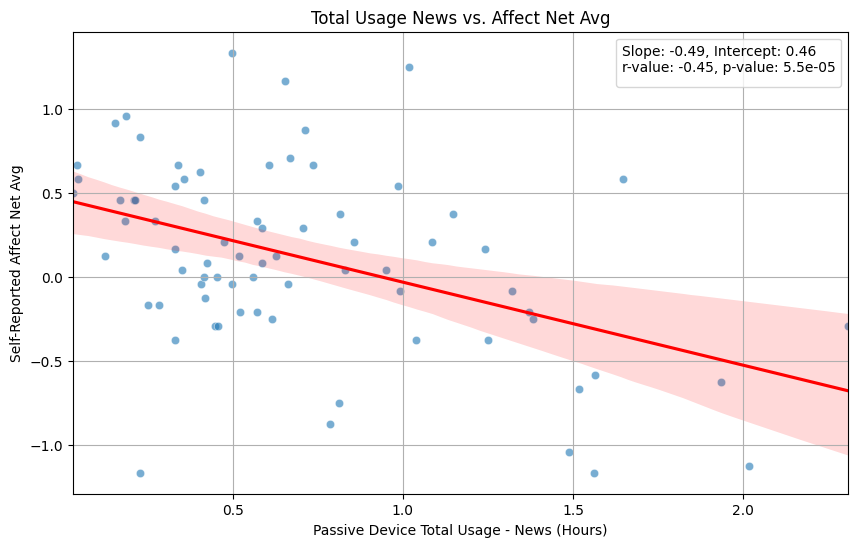

In [115]:
# Filtering data for the specific PID '2262249f-9158-4ba1-9555-fa961d86e92e'
specific_pid_data = df_filtered_clean[df_filtered_clean['PID'] == '2262249f-9158-4ba1-9555-fa961d86e92e']

# Filtering the specific PID data to exclude values over 10000 for 'passive_sk_device_total_usage_news'
specific_pid_data_filtered = specific_pid_data[specific_pid_data['passive_sk_device_total_usage_news'] <= 10000]
# Dividing the 'passive_sk_device_total_usage_news' by 3600 to convert values from seconds to hours for the specific PID data
specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'] = specific_pid_data_filtered['passive_sk_device_total_usage_news'] / 3600

# Plotting scatterplot with a regression line for the data converted to hours
plt.figure(figsize=(10, 6))

# Scatter plot of the data converted to hours
sns.scatterplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, alpha=0.6)

# Adding a regression line with confidence interval to show the strength and significance of the relationship
reg_line_hours = sns.regplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, 
                       scatter=False, color='red', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(*np.polyfit(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'], 1))})

# Calculating the regression statistics for the data in hours
slope_hours, intercept_hours, r_value_hours, p_value_hours, std_err_hours = stats.linregress(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'])

# Adding the line equation and stats to the plot
plt.legend(title=f"Slope: {slope_hours:.2f}, Intercept: {intercept_hours:.2f}\nr-value: {r_value_hours:.2f}, p-value: {p_value_hours:.2g}")

plt.title('Total Usage News vs. Affect Net Avg')
plt.xlabel('Passive Device Total Usage - News (Hours)')
plt.ylabel('Self-Reported Affect Net Avg')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


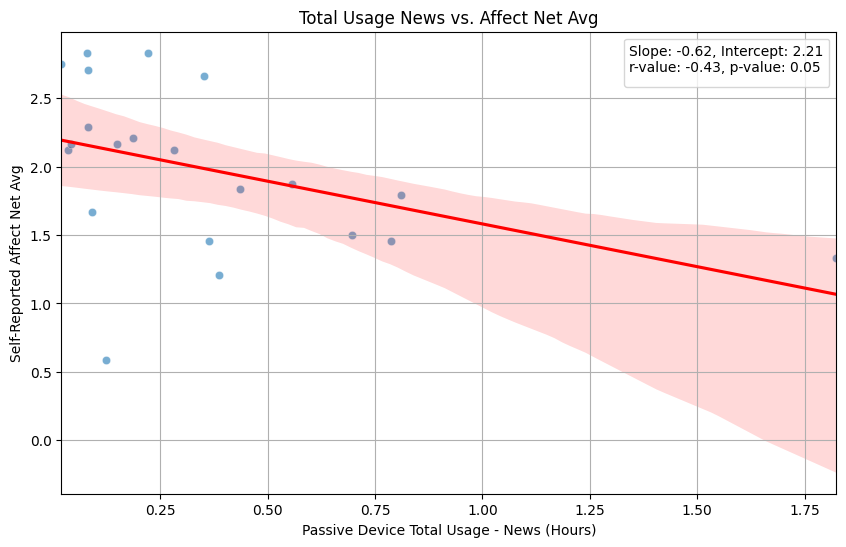

In [118]:
# Filtering data for the specific PID '2262249f-9158-4ba1-9555-fa961d86e92e'
specific_pid_data = df_filtered_clean[df_filtered_clean['PID'] == 'dfef360e-27cb-4d35-bb4a-d6633803eb96']

# Filtering the specific PID data to exclude values over 10000 for 'passive_sk_device_total_usage_news'
specific_pid_data_filtered = specific_pid_data[specific_pid_data['passive_sk_device_total_usage_news'] <= 10000]
# Dividing the 'passive_sk_device_total_usage_news' by 3600 to convert values from seconds to hours for the specific PID data
specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'] = specific_pid_data_filtered['passive_sk_device_total_usage_news'] / 3600

# Plotting scatterplot with a regression line for the data converted to hours
plt.figure(figsize=(10, 6))

# Scatter plot of the data converted to hours
sns.scatterplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, alpha=0.6)

# Adding a regression line with confidence interval to show the strength and significance of the relationship
reg_line_hours = sns.regplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, 
                       scatter=False, color='red', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(*np.polyfit(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'], 1))})

# Calculating the regression statistics for the data in hours
slope_hours, intercept_hours, r_value_hours, p_value_hours, std_err_hours = stats.linregress(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'])

# Adding the line equation and stats to the plot
plt.legend(title=f"Slope: {slope_hours:.2f}, Intercept: {intercept_hours:.2f}\nr-value: {r_value_hours:.2f}, p-value: {p_value_hours:.2g}")

plt.title('Total Usage News vs. Affect Net Avg')
plt.xlabel('Passive Device Total Usage - News (Hours)')
plt.ylabel('Self-Reported Affect Net Avg')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


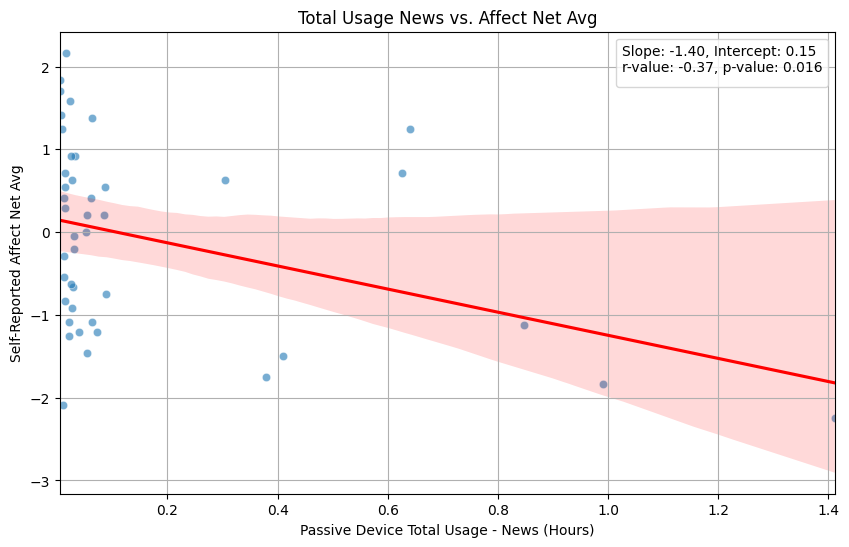

In [119]:
# Filtering data for the specific PID '2262249f-9158-4ba1-9555-fa961d86e92e'
specific_pid_data = df_filtered_clean[df_filtered_clean['PID'] == '0a06ff99-9b73-4f6a-8b36-cdf27b4c22fd']

# Filtering the specific PID data to exclude values over 10000 for 'passive_sk_device_total_usage_news'
specific_pid_data_filtered = specific_pid_data[specific_pid_data['passive_sk_device_total_usage_news'] <= 10000]
# Dividing the 'passive_sk_device_total_usage_news' by 3600 to convert values from seconds to hours for the specific PID data
specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'] = specific_pid_data_filtered['passive_sk_device_total_usage_news'] / 3600

# Plotting scatterplot with a regression line for the data converted to hours
plt.figure(figsize=(10, 6))

# Scatter plot of the data converted to hours
sns.scatterplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, alpha=0.6)

# Adding a regression line with confidence interval to show the strength and significance of the relationship
reg_line_hours = sns.regplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, 
                       scatter=False, color='red', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(*np.polyfit(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'], 1))})

# Calculating the regression statistics for the data in hours
slope_hours, intercept_hours, r_value_hours, p_value_hours, std_err_hours = stats.linregress(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'])

# Adding the line equation and stats to the plot
plt.legend(title=f"Slope: {slope_hours:.2f}, Intercept: {intercept_hours:.2f}\nr-value: {r_value_hours:.2f}, p-value: {p_value_hours:.2g}")

plt.title('Total Usage News vs. Affect Net Avg')
plt.xlabel('Passive Device Total Usage - News (Hours)')
plt.ylabel('Self-Reported Affect Net Avg')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


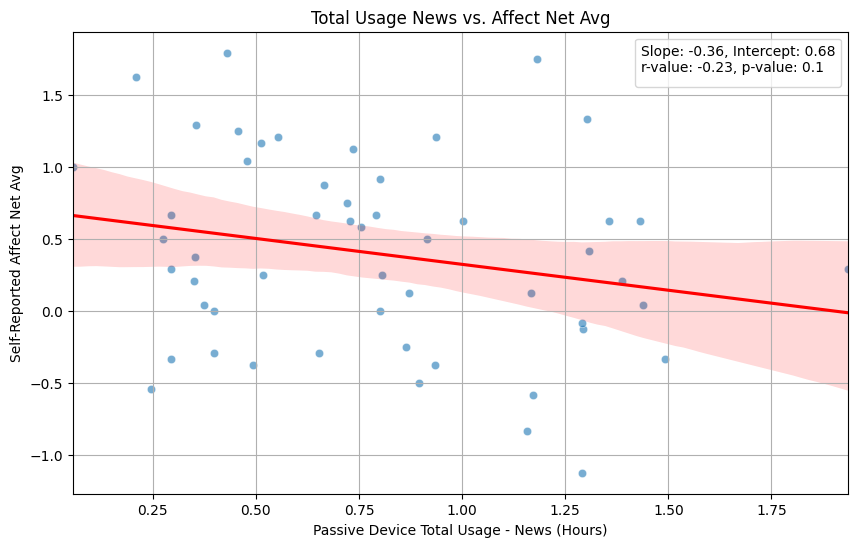

In [121]:
# Filtering data for the specific PID '2262249f-9158-4ba1-9555-fa961d86e92e'
specific_pid_data = df_filtered_clean[df_filtered_clean['PID'] == '117f2d92-eb60-4ed8-a99d-08ddbb775655']

# Filtering the specific PID data to exclude values over 10000 for 'passive_sk_device_total_usage_news'
specific_pid_data_filtered = specific_pid_data[specific_pid_data['passive_sk_device_total_usage_news'] <= 10000]
# Dividing the 'passive_sk_device_total_usage_news' by 3600 to convert values from seconds to hours for the specific PID data
specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'] = specific_pid_data_filtered['passive_sk_device_total_usage_news'] / 3600

# Plotting scatterplot with a regression line for the data converted to hours
plt.figure(figsize=(10, 6))

# Scatter plot of the data converted to hours
sns.scatterplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, alpha=0.6)

# Adding a regression line with confidence interval to show the strength and significance of the relationship
reg_line_hours = sns.regplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, 
                       scatter=False, color='red', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(*np.polyfit(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'], 1))})

# Calculating the regression statistics for the data in hours
slope_hours, intercept_hours, r_value_hours, p_value_hours, std_err_hours = stats.linregress(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'])

# Adding the line equation and stats to the plot
plt.legend(title=f"Slope: {slope_hours:.2f}, Intercept: {intercept_hours:.2f}\nr-value: {r_value_hours:.2f}, p-value: {p_value_hours:.2g}")

plt.title('Total Usage News vs. Affect Net Avg')
plt.xlabel('Passive Device Total Usage - News (Hours)')
plt.ylabel('Self-Reported Affect Net Avg')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


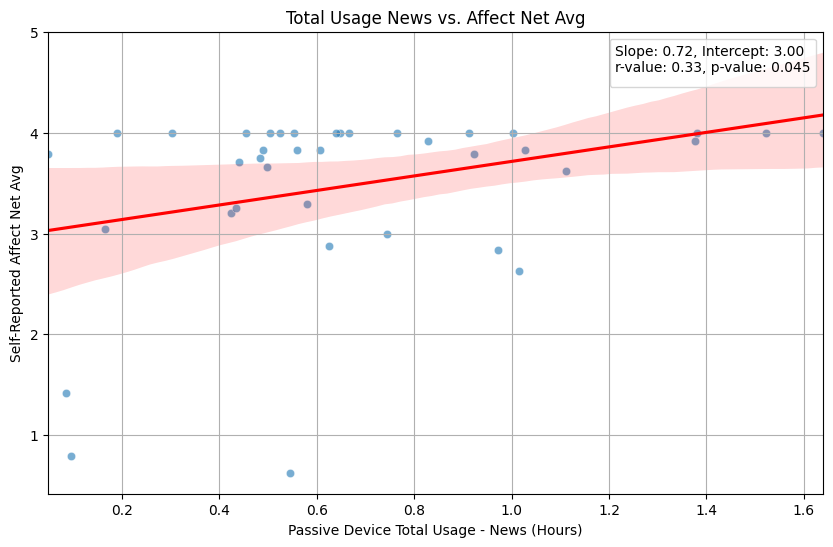

In [116]:
# Filtering data for the specific PID '2262249f-9158-4ba1-9555-fa961d86e92e'
specific_pid_data = df_filtered_clean[df_filtered_clean['PID'] == 'c62ae7a2-6fe6-4fd5-9b9e-93773b08d8b9']

# Filtering the specific PID data to exclude values over 10000 for 'passive_sk_device_total_usage_news'
specific_pid_data_filtered = specific_pid_data[specific_pid_data['passive_sk_device_total_usage_news'] <= 10000]
# Dividing the 'passive_sk_device_total_usage_news' by 3600 to convert values from seconds to hours for the specific PID data
specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'] = specific_pid_data_filtered['passive_sk_device_total_usage_news'] / 3600

# Plotting scatterplot with a regression line for the data converted to hours
plt.figure(figsize=(10, 6))

# Scatter plot of the data converted to hours
sns.scatterplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, alpha=0.6)

# Adding a regression line with confidence interval to show the strength and significance of the relationship
reg_line_hours = sns.regplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, 
                       scatter=False, color='red', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(*np.polyfit(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'], 1))})

# Calculating the regression statistics for the data in hours
slope_hours, intercept_hours, r_value_hours, p_value_hours, std_err_hours = stats.linregress(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'])

# Adding the line equation and stats to the plot
plt.legend(title=f"Slope: {slope_hours:.2f}, Intercept: {intercept_hours:.2f}\nr-value: {r_value_hours:.2f}, p-value: {p_value_hours:.2g}")

plt.title('Total Usage News vs. Affect Net Avg')
plt.xlabel('Passive Device Total Usage - News (Hours)')
plt.ylabel('Self-Reported Affect Net Avg')
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


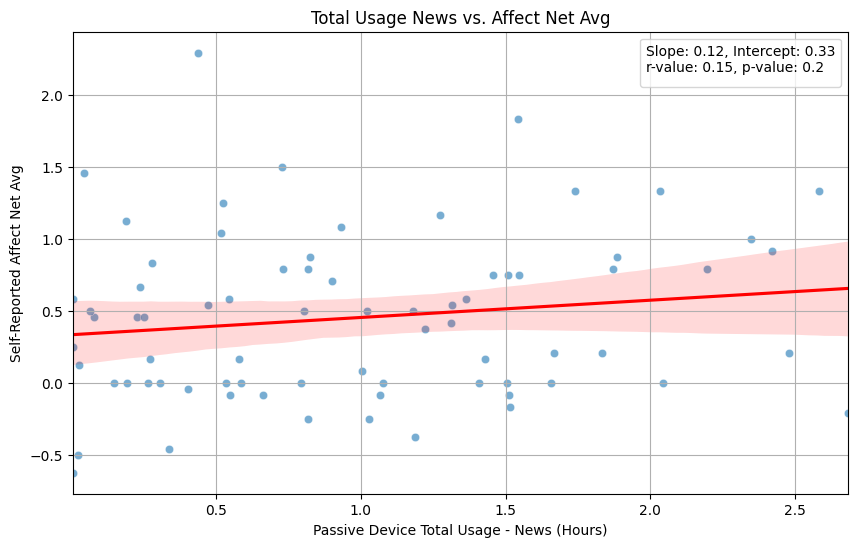

In [117]:
# Filtering data for the specific PID '2262249f-9158-4ba1-9555-fa961d86e92e'
specific_pid_data = df_filtered_clean[df_filtered_clean['PID'] == '4965aa0d-a7a9-4d1c-b835-3f79a29e0d39']

# Filtering the specific PID data to exclude values over 10000 for 'passive_sk_device_total_usage_news'
specific_pid_data_filtered = specific_pid_data[specific_pid_data['passive_sk_device_total_usage_news'] <= 10000]
# Dividing the 'passive_sk_device_total_usage_news' by 3600 to convert values from seconds to hours for the specific PID data
specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'] = specific_pid_data_filtered['passive_sk_device_total_usage_news'] / 3600

# Plotting scatterplot with a regression line for the data converted to hours
plt.figure(figsize=(10, 6))

# Scatter plot of the data converted to hours
sns.scatterplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, alpha=0.6)

# Adding a regression line with confidence interval to show the strength and significance of the relationship
reg_line_hours = sns.regplot(x='passive_sk_device_total_usage_news_hours', y='sr_affect_net_avg', data=specific_pid_data_filtered, 
                       scatter=False, color='red', line_kws={'label':"y={0:.1f}x+{1:.1f}".format(*np.polyfit(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'], 1))})

# Calculating the regression statistics for the data in hours
slope_hours, intercept_hours, r_value_hours, p_value_hours, std_err_hours = stats.linregress(specific_pid_data_filtered['passive_sk_device_total_usage_news_hours'], specific_pid_data_filtered['sr_affect_net_avg'])

# Adding the line equation and stats to the plot
plt.legend(title=f"Slope: {slope_hours:.2f}, Intercept: {intercept_hours:.2f}\nr-value: {r_value_hours:.2f}, p-value: {p_value_hours:.2g}")

plt.title('Total Usage News vs. Affect Net Avg')
plt.xlabel('Passive Device Total Usage - News (Hours)')
plt.ylabel('Self-Reported Affect Net Avg')
plt.grid(True)
plt.show()